In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
plt.style.use("paper.mplstyle")

from glob import glob
from tqdm import tqdm
from attrs import define

from scipy.interpolate import interp1d
from scipy.optimize import ridder

import os
os.environ["ASTERIA"] = "/Users/jlazar/research/ASTERIA"
import sys
sys.path.append("/Users/jlazar/research/ASTERIA/python/")
from ic_sn_hnl import units, parameterized_flux_from_files, ParameterizedFlux
from ic_sn_hnl.flux.parametrize_flux import Params, deserialize

In [3]:
TMAX = 100 * units["second"]
TMIN = 1e-2 * units["second"]
TMINS = np.logspace(np.log10(TMIN), np.log10(TMAX), 201)
TMAXS = np.logspace(np.log10(TMIN), np.log10(TMAX), 201)


In [4]:
with h5.File("data/SM_flux.h5", "r") as h5f:
    sm_flux = deserialize(h5f["SM_flux_thin_10_0"])

In [33]:
fs = glob("./data/magnetic_moment/from_yingying/*")
force = True
for f in tqdm(fs):

    x = f.split("/")[-1].replace(".csv", "_div6.npy")
    outfile = f"./data/magnetic_moment/per_flavor/{x}"
    if os.path.exists(outfile) and not force:
        continue
    arr = np.genfromtxt(f, delimiter=",")
    
    outarr = np.zeros(arr.shape)
    outarr[:, 0] = arr[:, 0]
    outarr[:, 1] = arr[:, 1]
    outarr[:, 2] = arr[:, 2] / 6
    
    if not np.all(arr[:, 0]==outarr[:, 0]):
        raise ValueError("Times are messed up")
    if not np.all(arr[:, 1]==outarr[:, 1]):
        raise ValueError("Energies are messed up")
    m1 = arr[:, 2] > 0
    m2 = outarr[:, 2] > 0
    if np.sum(m1)!=np.sum(m2):
        raise ValueError("Fluxes are messed up")
    r = arr[m1, 2] / outarr[m2, 2]
    if not np.all(r[~np.isnan(r)]==6):
        raise ValueError("Fluxes are messed up")
    np.save(outfile, outarr)

100%|██████████| 38/38 [05:15<00:00,  8.30s/it]


In [48]:
x = f.split("/")[-1].replace(".csv", "")

In [61]:
energies = np.sort(np.unique(arr[:, 1]))

In [62]:
energies

array([  0.,   3.,   6.,   9.,  12.,  15.,  18.,  21.,  24.,  27.,  30.,
        33.,  36.,  39.,  42.,  45.,  48.,  51.,  54.,  57.,  60.,  63.,
        66.,  69.,  72.,  75.,  78.,  81.,  84.,  87.,  90.,  93.,  96.,
        99., 102., 105., 108., 111., 114., 117., 120., 123., 126., 129.,
       132., 135., 138., 141., 144., 147., 150., 153., 156., 159., 162.,
       165., 168., 171., 174., 177., 180., 183., 186., 189., 192., 195.,
       198., 201., 204., 207., 210., 213., 216., 219., 222., 225., 228.,
       231., 234., 237., 240., 243., 246., 249., 252., 255., 258., 261.,
       264., 267., 270., 273., 276., 279., 282., 285., 288., 291., 294.,
       297., 300., 303., 306., 309., 312., 315., 318., 321., 324., 327.,
       330., 333., 336., 339., 342., 345., 348., 351., 354., 357., 360.,
       363., 366., 369., 372., 375., 378., 381., 384., 387., 390., 393.,
       396., 399.])

In [65]:
2680134 / len(energies)

20001.0

In [71]:
idx = 6

In [74]:
arr[idx*len(energies):(idx+1)*len(energies), 2]

array([-5.21064673e-16,  1.69923440e+01,  3.37734844e+01,  5.03310868e+01,
        6.66394893e+01,  8.26944128e+01,  9.83935200e+01,  1.13532236e+02,
        1.28098735e+02,  1.42046638e+02,  1.55331520e+02,  1.68002157e+02,
        1.80001427e+02,  1.91353325e+02,  2.02029642e+02,  2.12030061e+02,
        2.21330517e+02,  2.29951443e+02,  2.37833132e+02,  2.44994020e+02,
        2.51446103e+02,  2.57090069e+02,  2.61852690e+02,  2.65712572e+02,
        2.68666216e+02,  2.70734505e+02,  2.71795002e+02,  2.71907645e+02,
        2.71035757e+02,  2.69170982e+02,  2.66304512e+02,  2.62524266e+02,
        2.57974431e+02,  2.52558629e+02,  2.46364098e+02,  2.39371478e+02,
        2.31739111e+02,  2.23669531e+02,  2.15172715e+02,  2.06257664e+02,
        1.96933773e+02,  1.87361837e+02,  1.77741922e+02,  1.68089192e+02,
        1.58418751e+02,  1.48744643e+02,  1.39175604e+02,  1.29846716e+02,
        1.20765172e+02,  1.11956628e+02,  1.03433312e+02,  9.52372027e+01,
        8.74168006e+01,  

In [76]:
fluxes.shape

array([20001,   134,     3])

In [83]:
outfile = "./data/magnetic_moment/magnetic_moment_per_flavor.h5"
fs = glob("./data/magnetic_moment/from_yingying/*")

force = False

if not os.path.exists(outfile):
    with h5.File(outfile, "w") as _:
        pass

for f in tqdm(fs):
    key = f.split("/")[-1].replace(".csv", "")
    with h5.File(outfile, "r+") as h5f:
        # Clear it out of the way if we're forcing
        if force and key in h5f.keys():
            del h5f[key]
        # Move on to next file if not forcing and already there
        elif key in h5f.keys():
            continue
            
    
    arr = np.genfromtxt(f, delimiter=",")
    times = np.sort(np.unique(arr[:, 0]))
    energies = np.sort(np.unique(arr[:, 1]))
    fluxes = np.empty(times.shape + energies.shape + (3,))
    
    for idx in range(len(times)):
        flux = arr[idx*len(energies):(idx+1)*len(energies), 2] / 6
        flux = np.where(flux>=0, flux, 0)
        fluxes[idx, :, 0] = flux
        fluxes[idx, :, 1] = flux
        fluxes[idx, :, 2] = flux
        
    with h5.File(outfile, "r+") as h5f:
        h5f.create_group(key)
        h5f[key].create_dataset("energies", data=energies)
        h5f[key].create_dataset("times", data=times)
        h5f[key].create_dataset("fluxes", data=fluxes)
        

100%|██████████| 38/38 [04:39<00:00,  7.35s/it]


In [42]:
np.unique(arr[:, 0])

array([1.0000e-03, 2.0000e-03, 3.0000e-03, ..., 1.9999e+01, 2.0000e+01,
       2.0001e+01])

In [36]:
fs = glob("./data/magnetic_moment/per_flavor/*_div6.npy")
h5fname = "data/magnetic_moment/serialized_fluxes.h5"
thin = 100
force = True

if not os.path.exists(h5fname):
    with h5.File(h5fname, "w") as _:
        pass

for f in fs:
    desc = f.split("/")[-1].replace(".csv", "")
    log_coupling = float(f"-{desc.split('-')[3][2:].replace('dot', '.')}")
    mass = float(desc.split('-')[2].replace("MeV", ""))
    if mass >= 340:
        continue
    print(f"{desc}_0")
    with h5.File(h5fname, "r") as h5f:
        if f"{desc}_0" in h5f.keys() and not force:
            print()
            continue
    flux = parameterized_flux_from_files(f, f, f, 10*units["kpc"], thin=thin)
    flux.serialize(h5fname, groupname=desc, mass=mass, log_coupling=log_coupling, thin=thin)

dphi-dEdt-200MeV-dn14dot5-nf_div6.npy_0


100%|██████████| 201/201 [01:16<00:00,  2.63it/s]


dphi-dEdt-200MeV-dn12dot3-nf_div6.npy_0


100%|██████████| 201/201 [00:04<00:00, 45.13it/s]


dphi-dEdt-1MeV-dn12dot3-nf_div6.npy_0


  1%|          | 2/201 [00:00<01:15,  2.63it/s]/Users/jlazar/research/ic_sn_bsm/ic_sn_hnl/flux/parametrize_flux.py:373: RuntimeWarning: divide by zero encountered in divide
  f = lambda e: interp(e) / hack
/Users/jlazar/research/ic_sn_bsm/ic_sn_hnl/flux/parametrize_flux.py:381: RuntimeWarning: invalid value encountered in multiply
  return m * hack
 22%|██▏       | 45/201 [00:16<00:53,  2.90it/s]/Users/jlazar/research/ic_sn_bsm/ic_sn_hnl/flux/parametrize_flux.py:374: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  m, err = quad(f, e.min(), e.max())
 80%|███████▉  | 160/201 [00:51<00:13,  3.12it/s]


KeyboardInterrupt: 

In [8]:
def likelihood(sig_hits, sm_hits, bg_hits):
    n_obs = (bg_hits + sm_hits).sum()
    n_exp = (sig_hits + bg_hits + sm_hits).sum()
    llh = 2 * (n_exp - n_obs)
    if n_obs > 0:
        llh += 2 * n_obs * np.log(n_obs / n_exp)
    return llh

In [9]:
def find_significance_matrix(sig_hits, sm_hits, bg_hits, times, tmins=TMINS, tmaxs=TMAXS):
    significance = np.full(tmins.shape + tmaxs.shape, np.nan)

    for idx, tmin in enumerate(tmins):
        for jdx, tmax in enumerate(tmaxs):
            m = np.logical_and(tmin < times, times < tmax)
            # print(m.shape)
            if not m.sum():
                continue
            significance[idx, jdx] = likelihood(sig_hits[m], sm_hits[m], bg_hits[m])
    return significance, tmins, tmaxs

In [17]:
@define
class Hypothesis:
    coupling: float
    mass: float
@define
class Result:
    hypothesis: Hypothesis
    significance: float

In [19]:
sm_t, sm_hits = sm_flux.get_hits()
out = {}

with h5.File("data/magnetic_moment/serialized_fluxes.h5", "r") as h5f:
    print(h5f.keys())
    for key in h5f.keys():
        key_split = key.split("_")[0].split("-")
        mass = float(key_split[2].replace("MeV", ""))
        if mass not in out:
            out[mass] = []
        coupling = float(f"-{key_split[3][2:].replace('dot', '.')}")
        hypothesis = Hypothesis(coupling, mass)
        
        flux = deserialize(h5f[key])
        
        bsm_t, bsm_hits = flux.get_hits(model_file="magnetic_moment.txt")
        bg_hits = flux.get_background(
            shape=bsm_hits.shape,
            model_file="magnetic_moment.txt"
        )
        
        if np.any(sm_t!=bsm_t):
            raise ValueError("Hit times are different !")
            
        significance, _, _ = find_significance_matrix(bsm_hits, sm_hits, bg_hits, bsm_t)
        m = ~np.isnan(significance)
        
        out[mass].append(Result(hypothesis, significance[m].max()))

<KeysViewHDF5 []>


In [12]:
a = []
for k, v in out.items():
    
    cs, ss = 10**np.array([x[0] for x in v]), np.array([x[1] for x in v])
    sorter = np.argsort(cs)    
    cs, ss = cs[sorter], ss[sorter]
    
    interp = interp1d(np.log(cs), np.log(ss))
    f = lambda lc: np.exp(interp(lc)) - 3.841
    try:
        res = ridder(f, np.log(cs[0]), np.log(cs[-1]))
        plt.scatter(np.exp(res), np.exp(interp(res)), color="darkorange")
    except ValueError:
        pass

    a.append((k, np.exp(res)))
    plt.scatter(cs, ss, color="k", label="Sampled points")
    plt.plot(cs, ss, color="k", label="Interpolated LLH")

    plt.xlabel(r"$d_{n}$", fontsize=22)
    plt.ylabel(r"$LLH$", fontsize=22)
    plt.axhline(3.841, label=r"Sensitivity", ls="--", color="darkorange", alpha=0.4)
    plt.title(f"Mass = {k} MeV")
    plt.loglog()
    # plt.ylim()
    plt.legend(fontsize=15)
    plt.savefig(f"figures/magnetic_moment_sensitivities_{k}.pdf")
    plt.show()

In [ ]:
a = sorted(a, key=lambda x: x[0])

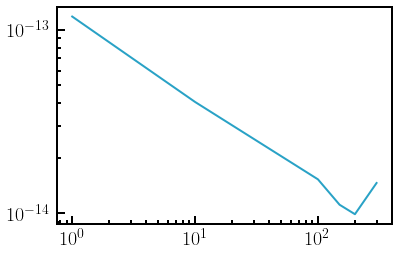

In [22]:

plt.plot([x[0] for x in a], [x[1] for x in a])
plt.loglog()
plt.show()

In [6]:
fs = [
    "./data/dphi-dEdt-1MeV-dn13-nf_div6.csv",
    "./data/dphi-dEdt-10MeV-dn13dot3-nf_div6.csv",
    "./data/dphi-dEdt-100MeV-dn13dot8-nf_div6.csv",
    "./data/dphi-dEdt-150MeV-dn13dot9-nf_div6.csv",
    "./data/dphi-dEdt-200MeV-dn14-nf_div6.csv",
    "./data/dphi-dEdt-300MeV-dn13dot8-nf_div6.csv",
] + glob("./data/dp*100s*_div6.csv")

bsm_fluxes = []
with h5.File("data/BSM_fluxes.h5", "r") as h5f:
    for idx in tqdm(range(11)):
        k = f"parameterized_flux_{idx}"
        g = h5f[k]
        flux = deserialize(g)
        bsm_fluxes.append(flux)

try:
    itr = fs[len(bsm_fluxes):]
except NameError:
    bsm_fluxes = []
    itr = fs
bsm_fluxes = []
itr = fs
    
for f in itr:
    flux = parameterized_flux_from_txt_files(f, f, f, 10*units["kpc"], thin=10)
    flux.serialize("data/BSM_fluxes.h5")
    bsm_fluxes.append(flux)

100%|██████████| 11/11 [01:15<00:00,  6.84s/it]


./data/dphi-dEdt-340MeV-dn13dot8-nf_div6.csv


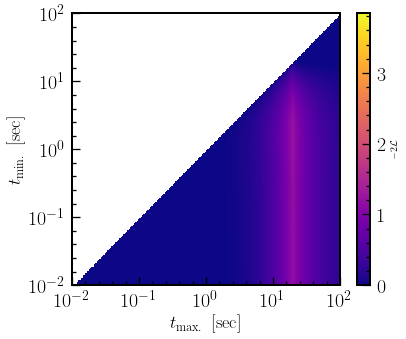

[1.51356125] [19.95262315]


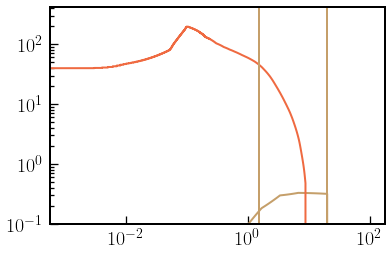

./data/dphi-dEdt-1MeV-gn10-100s-nf_div6.csv


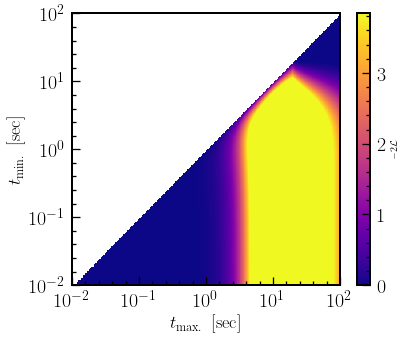

[1.] [19.95262315]


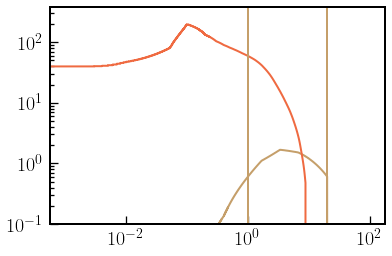

./data/dphi-dEdt-360MeV-dn13dot3-nf_div6.csv


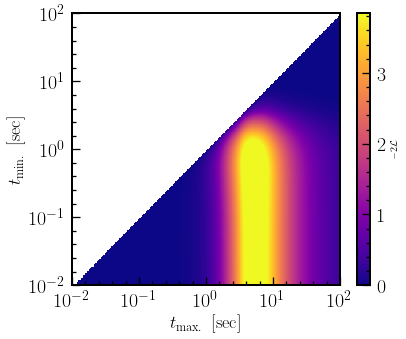

[0.52480746] [5.01187234]


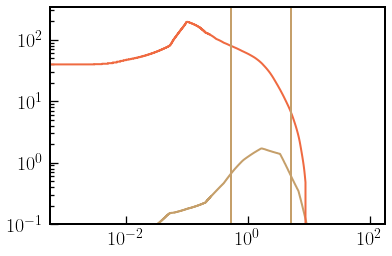

./data/dphi-dEdt-300MeV-dn13dot8-nf_div6.csv


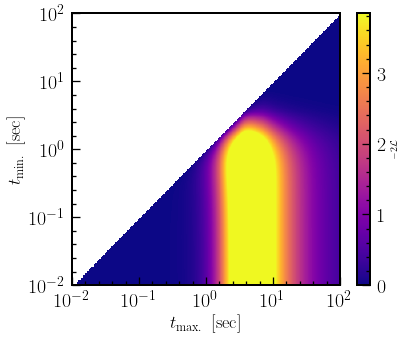

[0.45708819] [4.16869383]


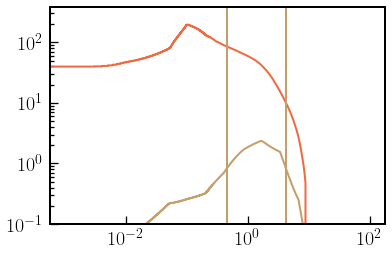

./data/dphi-dEdt-380MeV-dn14-nf_div6.csv


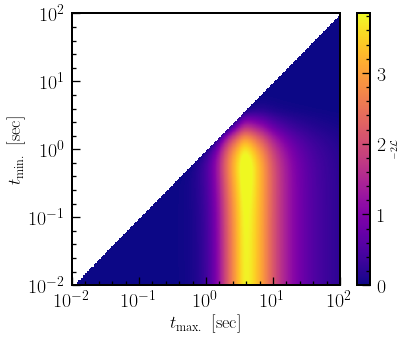

[0.47863009] [3.98107171]


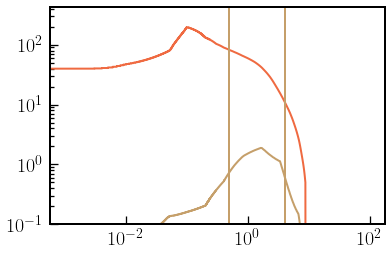

./data/dphi-dEdt-340MeV-dn13-nf_div6.csv


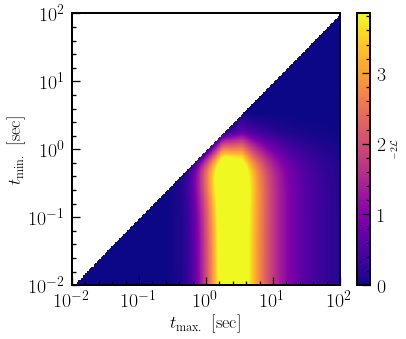

[0.31622777] [1.99526231]


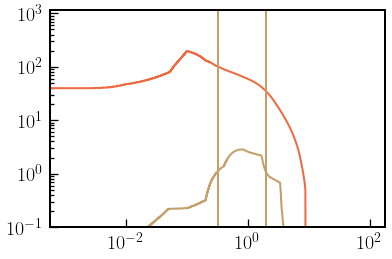

./data/dphi-dEdt-200MeV-dn14dot3-nf_div6.csv


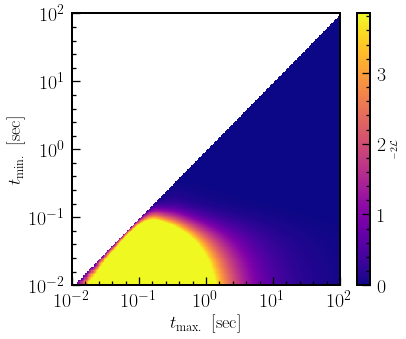

[0.01       0.01047129 0.01096478] [0.11481536 0.11481536 0.11481536]


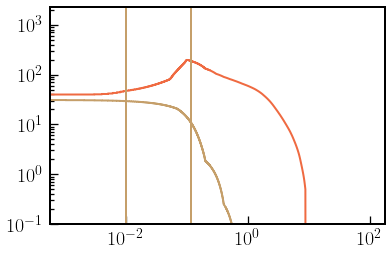

./data/dphi-dEdt-100MeV-gn11-100s-nf_div6.csv


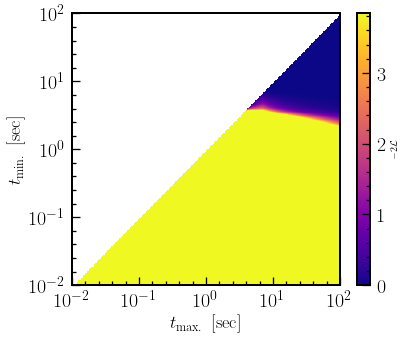

[0.01       0.01047129 0.01096478] [0.87096359 0.87096359 0.87096359]


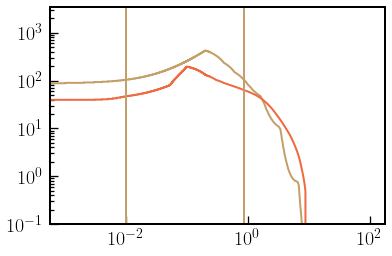

./data/dphi-dEdt-1MeV-dn13dot3-nf_div6.csv


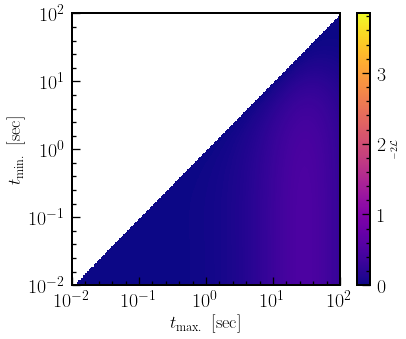

[0.05495409] [30.1995172]


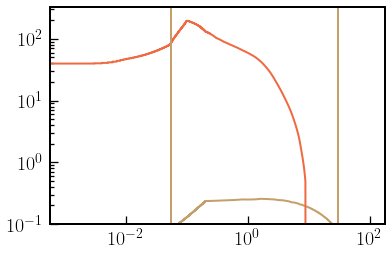

./data/dphi-dEdt-200MeV-dn14-nf_div6.csv


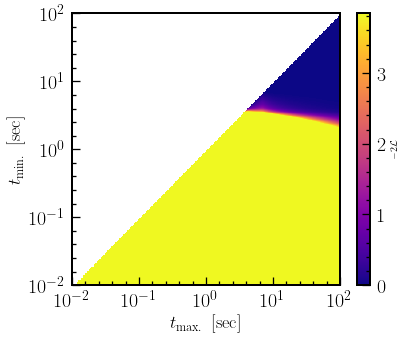

[0.01       0.01047129 0.01096478] [0.63095734 0.63095734 0.63095734]


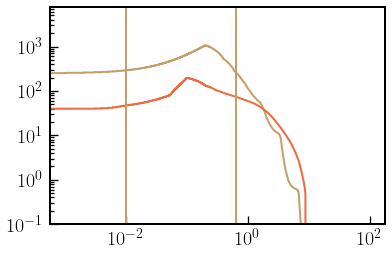

./data/dphi-dEdt-360MeV-dn12dot5-nf_div6.csv


KeyboardInterrupt: 

In [54]:
TMAX = 100 * units["second"]
TMIN = 1e-2 * units["second"]
tmins = np.logspace(np.log10(TMIN), np.log10(TMAX), 201)
tmaxs = np.logspace(np.log10(TMIN), np.log10(TMAX), 201)

# try:
#     sm_t
# except NameError:
sm_t, sm_hits = sm_flux.get_hits(tmax=TMAX)

for flux, f in zip(bsm_fluxes, fs):
    print(f)
    t, hits = flux.get_hits(tmax=TMAX)
    bg = flux.get_background(tmax=TMAX, shape=t.shape)

#     significance = np.full(tmins.shape + tmaxs.shape, np.nan)

#     for idx, tmin in enumerate(tmins):
#         for jdx, tmax in enumerate(tmaxs):
#             m = np.logical_and(tmin < t, t < tmax)
#             n_bsm = (hits[m] + sm_hits[m] + bg[m]).sum()
#             n_sm = (sm_hits[m] + bg[m]).sum()
#             # all_cts = (hits[m] + sm_hits[m] + bg[m]).sum()
#             # if n_sm
#             if n_sm==0:
#                 continue
#             # bsm_cts = hits[m].sum()
#             significance[idx, jdx] = 2 * (n_bsm - n_sm + n_sm*np.log(n_sm / n_bsm))
    significance, _, _ = find_significance_matrix(hits, sm_hits, bg)

    fig, ax = plt.subplots(figsize=(6,5))

    im = ax.imshow(
        significance[::-1],
        extent=[
            np.log10(TMIN/units["second"]),
            np.log10(TMAX/units["second"]),
            np.log10(TMIN/units["second"]), 
            np.log10(TMAX/units["second"])
        ],
        aspect="auto",
        vmin=0,
        vmax=3.841
    )

    ax.set(
        xlim=(np.log10(TMIN/units["second"]), np.log10(TMAX/units["second"])),
        ylim=(np.log10(TMIN/units["second"]), np.log10(TMAX/units["second"])),
    )
    ax.set_xlabel(r"$t_{\rm{max.}}~\left[\mathrm{sec}\right]$", fontsize=18)
    ax.set_ylabel(r"$t_{\rm{min.}}~\left[\mathrm{sec}\right]$", fontsize=18)
    xticks = [-2, -1, 0, 1, 2]
    yticks = [-2, -1, 0, 1, 2]
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels([r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$", r"$10^{1}$", r"$10^{2}$"])
    ax.set_yticklabels([r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$", r"$10^{1}$", r"$10^{2}$"])

    cbar = plt.colorbar(im, label=r"$-2\mathcal{L}$")

    plt.show()
    
    m = ~np.isnan(significance)
    argx, argy = np.where(significance==significance[m].max())
    print(tmins[argx]/units["second"], tmaxs[argy]/units["second"])
    
    fig, ax = plt.subplots()
    ax.step(t / units["second"], hits)
    ax.step(sm_t / units["second"], sm_hits)
    ax.axvline(tmins[argx][0]/units["second"])
    ax.axvline(tmins[argy][0]/units["second"])
    ax.loglog()
    ax.set_ylim(1e-1, None)
    plt.show()

In [87]:
tmins = np.linspace(5e-3, 20, 201) * units["second"]
tmaxs = np.linspace(5e-3, 20, 201) * units["second"]

for flux, f in zip(bsm_fluxes, fs):
    print(f)
    t, hits = flux.get_hits()
    bg = flux.get_background()

    significance = np.full(tmins.shape + tmaxs.shape, np.nan)

    for idx, tmin in enumerate(tmins):
        for jdx, tmax in enumerate(tmaxs):
            m = np.logical_and(tmin < t, t < tmax)
            # nobs
            all_cts = (hits[m] + sm_hits[m] + bg[m]).sum()
            if all_cts==0:
                continue
            bsm_cts = hits[m].sum()
            significance[idx, jdx] = bsm_cts / np.sqrt(all_cts)


    fig, ax = plt.subplots(figsize=(6,5))
    # [x.set_linewidth(1.5) for x in ax.spines.values()]

    im = ax.imshow(
        significance[::-1],
        extent=[0, 20, 0, 20],
        aspect="auto"
    )

    ax.set(
        xlim=(0, 20),
        ylim=(0, 20),
        xlabel=r"$t_{\rm{max}}~\left[{\rm{sec}}\right]$",
        ylabel=r"$t_{\rm{min}}~\left[{\rm{sec}}\right]$",
    )

    cbar = plt.colorbar(im, label=r"$\frac{N_{\rm{BSM}}}{\sqrt{N_{\rm{tot.}}}}$")

    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot(t / units["second"], hits)
    plt.show()

./data/dphi-dEdt-1MeV-dn13-nf_div6.csv


IndexError: boolean index did not match indexed array along dimension 0; dimension is 101002 but corresponding boolean dimension is 21001

In [114]:
f = "./data/dphi-dEdt-150MeV-dn13dot9-nf_div6.csv"
params_f = f"{f.replace('.csv', '_params.txt')}"
print(params_f)
re_param = False
if re_param:
    bsm_flux = ParameterizedFlux(f, f, f, 10*units["kpc"])
    bsm_flux.parameterize(thin=10)
ts, hits = bsm_flux.get_hits()

bsm_model = {
    'name': 'Analytic3Species',
    'param': {
        'filename': params_f
    }
}

bsm_sim = Simulation(
    distance=1.0 * u.m,
    model=bsm_model,
    **sim_kwargs
)


bsm_sim.run()
bsm_sim.rebin_result(dt)
bsm_t, bsm_hits = bsm_sim.detector_signal(dt)

./data/dphi-dEdt-150MeV-dn13dot9-nf_div6_params.txt


In [22]:
bsm_fluxes = []

fs = [
    "./data/dphi-dEdt-100MeV-dn13-nf.csv"
]

for f in fs:
    f_ = f.replace(".csv", "_div6.csv")
    print(f_)
    title = f.split("/")[-1].split(".")[0]
    
    bsm_flux = ParameterizedFlux(f_, f_, f_, 10*units["kpc"])
    bsm_flux.parameterize(thin=10)
    # params_f = f"{f.replace('.csv', '_params.txt')}"
    # bsm_flux.write_params(params_f, scale=(units["m"] / (10 * units["kpc"]))**2)
    # bsm_fluxes.append(bsm_flux)

./data/dphi-dEdt-300MeV-dn14dot5-nf_div6.csv


In [ ]:
params = []
for f in fs:
    fsplit = f.split("-")
    a = fsplit[2].replace("MeV", "")
    b = fsplit[3].replace("dn", "").replace("dot", ".")
    mass = float(a)
    try:
        coupling = -float(b)
    except ValueError:
        coupling = -13.0
    params.append((mass, coupling))

./data/dphi-dEdt-300MeV-dn14dot5-nf.csv
./data/dphi-dEdt-300MeV-dn14dot5-nf_div6.csv
dphi-dEdt-300MeV-dn14dot5-nf
./data/dphi-dEdt-300MeV-dn14dot5-nf_params.txt
8023.927760436302
196706.04100855315


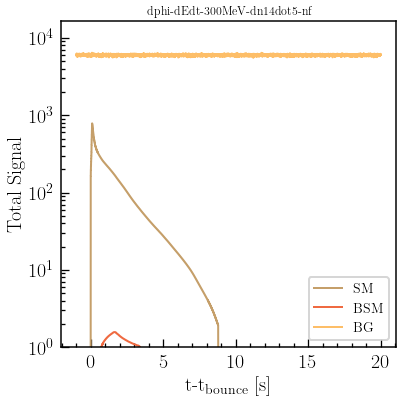

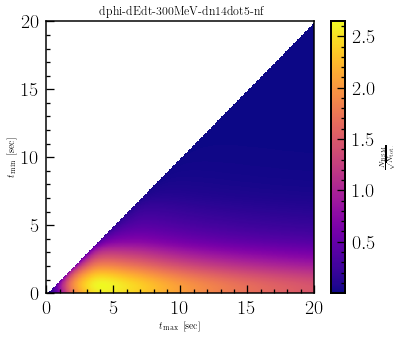

(2.645144566514507, 0.5, 4.2)


In [76]:
# bsm_fluxes = []
ahhhh = {}
for f, bsm_flux in zip(fs, [bsm_flux]):
    print(f)
    f_ = f.replace(".csv", "_div6.csv")
    print(f_)
    print(f.split("/")[-1].split(".")[0])
    title = f.split("/")[-1].split(".")[0]
    
    # bsm_flux = ParameterizedFlux(f_, f_, f_, 10*units["kpc"])
    
    params_f = f"{f.replace('.csv', '_params.txt')}"
    print(params_f)
    bsm_flux._write_params(params_f, scale=(units["m"] / (10 * units["kpc"]))**2)

    bsm_model = {
        'name': 'Analytic3Species',
        'param': {
            'filename': params_f
        }
    }

    sm_model = {
        'name': 'Analytic3Species',
        'param': {
            'filename': "data/sm_params.txt"
        }
    }

    bsm_sim = Simulation(
        # distance=1*u.kpc,
        distance=1.0 * u.m,
        model=bsm_model,
        **sim_kwargs
    )

    sm_sim = Simulation(
        model=sm_model,
        distance=1.0 * u.m,
        **sim_kwargs
    )

    dt = 0.004 * u.s

    bsm_sim.run()
    bsm_sim.rebin_result(dt)
    bsm_t, bsm_hits = bsm_sim.detector_signal(dt)
    print(bsm_hits.sum())

    sm_sim.run()
    sm_sim.rebin_result(dt)
    sm_t, sm_hits = sm_sim.detector_signal(dt)
    print(sm_hits.sum())

    sm_bg = sm_sim.detector.i3_bg(dt, size=sm_hits.size) + sm_sim.detector.dc_bg(dt, size=sm_hits.size)

    fig, ax = plt.subplots(1, figsize = (6,6))

    kwargs = {
        "step": "post",
        "edgecolor": "k",
        # "lw": "2"
    }
    ax.step(
        sm_t,
        sm_hits,
        label=r"SM",
        # **kwargs
    )
    ax.step(
        bsm_t,
        bsm_hits / 6,
        label=r"BSM",
        # **kwargs
    )
    ax.step(
        bsm_t,
        sm_bg,
        label=r"BG",
        # **kwargs
    )
    ax.legend(fontsize=14)
    ax.semilogy()
    # ax.set(xlim=(0.05, 0.65))
    ax.set_ylim(1.0, None)
    ax.set_xlabel(r't-t$_{\rm{bounce}}$ [s]', fontsize=20)
    ax.set_ylabel(fr'Total Signal', fontsize=20)
    ax.set_title(title)
    [x.set_linewidth(1.5) for x in ax.spines.values()]

    plt.show()

    tmins = np.linspace(0, 20, 201)
    tmaxs = np.linspace(0, 20, 201)

    significance = np.full(tmins.shape + tmaxs.shape, np.nan)

    for idx, tmin in enumerate(tmins):
        for jdx, tmax in enumerate(tmaxs):
            m = np.logical_and(tmin < bsm_t.value, bsm_t.value < tmax)
            all_cts = (bsm_hits[m] + sm_hits[m] + sm_bg[m]).sum()
            if all_cts==0:
                continue
            bsm_cts = bsm_hits[m].sum()      
            significance[idx, jdx] = bsm_cts / np.sqrt(all_cts)


    fig, ax = plt.subplots(figsize=(6,5))
    [x.set_linewidth(1.5) for x in ax.spines.values()]

    im = ax.imshow(
        significance[::-1],
        extent=[0, 20, 0, 20],
        aspect="auto"
    )
    ax.set_title(title)
    ax.set(
        xlim=(0, 20),
        ylim=(0, 20),
        xlabel=r"$t_{\rm{max}}~\left[{\rm{sec}}\right]$",
        ylabel=r"$t_{\rm{min}}~\left[{\rm{sec}}\right]$",
    )

    cbar = plt.colorbar(im, label=r"$\frac{N_{\rm{BSM}}}{\sqrt{N_{\rm{tot.}}}}$")

    plt.show()
    
    fsplit = f.split("-")
    a = fsplit[2].replace("MeV", "")
    b = fsplit[3].replace("dn", "").replace("dot", ".")
    mass = float(a)
    try:
        coupling = -float(b)
    except ValueError:
        coupling = -13.0
    smax = 0
    for idx in range(significance.shape[0]):
        for jdx in range(significance.shape[1]):
            if np.isnan(significance[idx, jdx]):
                continue
            smax = max(smax, significance[idx, jdx])
            if smax != significance[idx, jdx]:
                continue
            tmin0 = tmins[idx]
            tmax0 = tmaxs[jdx]
    print((smax, tmin0, tmax0))
    ahhhh[(mass, coupling)] = (smax, tmin0, tmax0)

In [ ]:
fig, ax = plt.subplots()

sct = ax.scatter(
    [k[0] for k in ahhhh.keys()],
    [10**k[1] for k in ahhhh.keys()],
    c = np.log10([2*v[0]**2 for v in ahhhh.values()]),
    vmax=np.log10(2.71),
)
ax.set(
    yscale="log",
    # xscale="log"
)
ax.set_xlabel(r"$m_{\rm{HNL}}~\left[{\rm{MeV}}\right]$", fontsize=20)
ax.set_ylabel(r"$d~\left[{\rm{MeV}}^{-1}\right]$", fontsize=20)
cbar = plt.colorbar(sct)
cbar.set_label(label=r"$\log_{10}({\rm{TS}})$", fontsize=20)
plt.show()

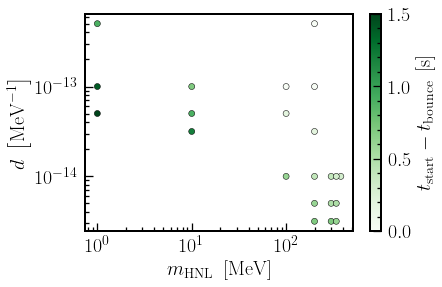

In [16]:
fig, ax = plt.subplots()

sct = ax.scatter(
    [k[0] for k in ahhhh.keys()],
    [10**k[1] for k in ahhhh.keys()],
    c = [v[1] for v in ahhhh.values()],
    cmap="Greens",
    edgecolor="k",
    linewidth=0.5
)
ax.set(
    yscale="log",
    xscale="log"
)
ax.set_xlabel(r"$m_{\rm{HNL}}~\left[{\rm{MeV}}\right]$", fontsize=20)
ax.set_ylabel(r"$d~\left[{\rm{MeV}}^{-1}\right]$", fontsize=20)
cbar = plt.colorbar(sct)
cbar.set_label(label=r"$t_{\rm{start}} - t_{\rm{bounce}}~\left[{\rm{s}}\right]$", fontsize=20)
plt.show()

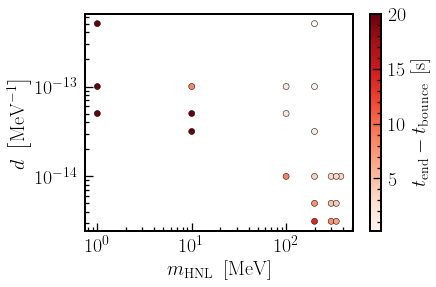

In [17]:
fig, ax = plt.subplots()

sct = ax.scatter(
    [k[0] for k in ahhhh.keys()],
    [10**k[1] for k in ahhhh.keys()],
    c = [v[2] for v in ahhhh.values()],
    cmap="Reds",
    edgecolor="k",
    linewidth=0.5
)
ax.set(
    yscale="log",
    xscale="log"
)
ax.set_xlabel(r"$m_{\rm{HNL}}~\left[{\rm{MeV}}\right]$", fontsize=20)
ax.set_ylabel(r"$d~\left[{\rm{MeV}}^{-1}\right]$", fontsize=20)
cbar = plt.colorbar(sct)
cbar.set_label(label=r"$t_{\rm{end}} - t_{\rm{bounce}}~\left[{\rm{s}}\right]$", fontsize=20)
plt.show()

## Calculate using the same likelihood as other paper

In [18]:
n_sm

30119094.769825213

In [19]:
n_bsm

30119356.935164012

In [17]:
print(2 * (n_bsm - n_sm + n_sm * np.log(n_sm/n_bsm)))

0.0022819494638497417


./data/dphi-dEdt-300MeV-dn14dot5-nf.csv
./data/dphi-dEdt-300MeV-dn14dot5-nf_div6.csv
dphi-dEdt-300MeV-dn14dot5-nf
./data/dphi-dEdt-300MeV-dn14dot5-nf_params.txt
262.1659910174996
198081.11721088225


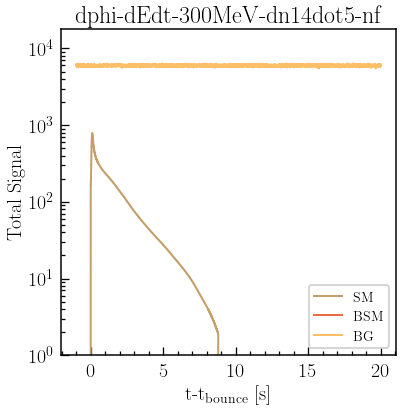

/var/folders/4q/ncd7kk_j2t9_syxd3gmst9mc0000gn/T/ipykernel_62163/1216984475.py:103: RuntimeWarning: invalid value encountered in scalar divide
  significance[idx, jdx] = 2 * (n_bsm - n_sm + n_sm * np.log(n_sm/n_bsm))


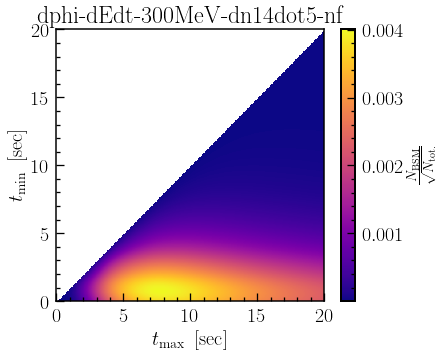

(0.004004046235138503, 0.7000000000000001, 7.800000000000001)
./data/dphi-dEdt-200MeV-dn14dot3-nf.csv
./data/dphi-dEdt-200MeV-dn14dot3-nf_div6.csv
dphi-dEdt-200MeV-dn14dot3-nf
./data/dphi-dEdt-200MeV-dn14dot3-nf_params.txt
1470.6724541684018
198081.11721088225


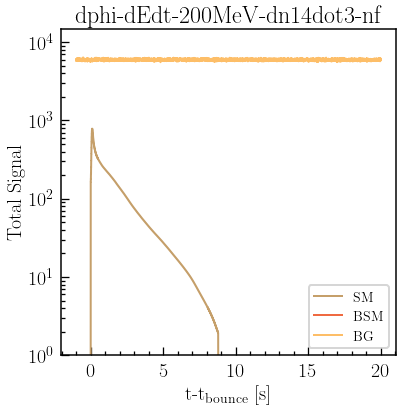

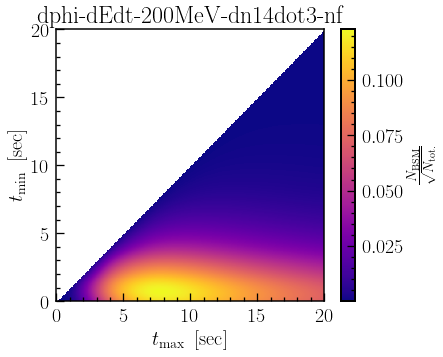

(0.1228432523698757, 0.7000000000000001, 7.800000000000001)
./data/dphi-dEdt-300MeV-dn14-nf.csv
./data/dphi-dEdt-300MeV-dn14-nf_div6.csv
dphi-dEdt-300MeV-dn14-nf
./data/dphi-dEdt-300MeV-dn14-nf_params.txt
2413.534520475245
198081.11721088225


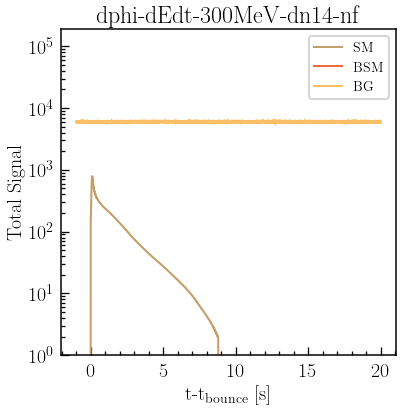

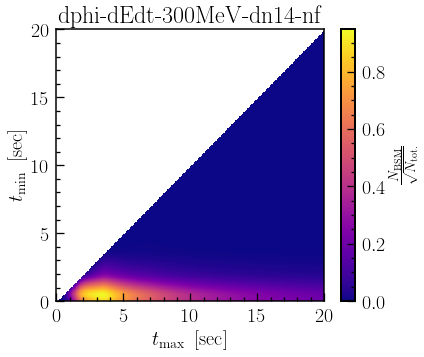

(0.9470382029667235, 0.4, 3.4000000000000004)
./data/dphi-dEdt-360MeV-dn13dot3-nf.csv
./data/dphi-dEdt-360MeV-dn13dot3-nf_div6.csv
dphi-dEdt-360MeV-dn13dot3-nf
./data/dphi-dEdt-360MeV-dn13dot3-nf_params.txt
1302.9516539064364
198081.11721088225


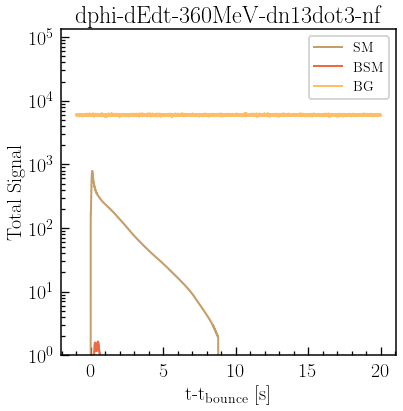

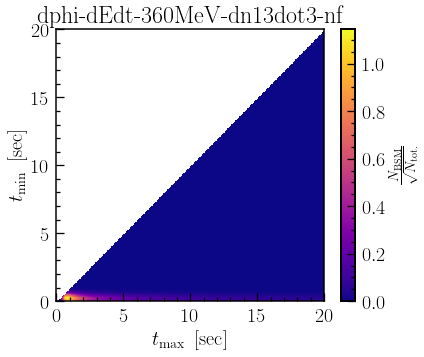

(1.1444326463420111, 0.2, 0.8)
./data/dphi-dEdt-380MeV-dn13dot5-nf.csv
./data/dphi-dEdt-380MeV-dn13dot5-nf_div6.csv
dphi-dEdt-380MeV-dn13dot5-nf
./data/dphi-dEdt-380MeV-dn13dot5-nf_params.txt
370.4754178445182
198081.11721088225


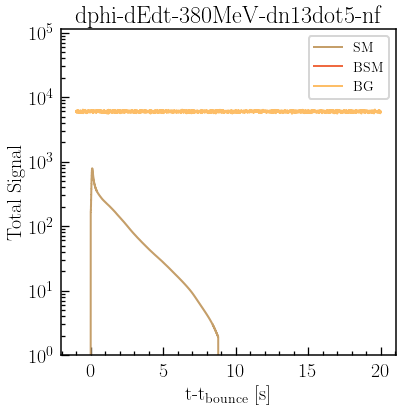

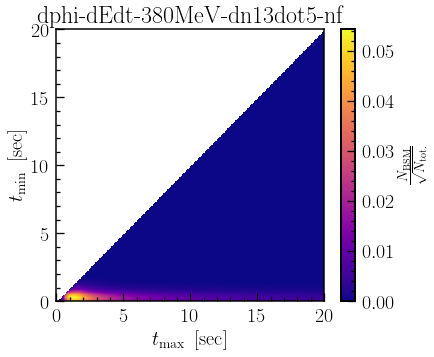

(0.05432210618209865, 0.2, 1.3)
./data/dphi-dEdt-340MeV-dn14dot5-nf.csv
./data/dphi-dEdt-340MeV-dn14dot5-nf_div6.csv
dphi-dEdt-340MeV-dn14dot5-nf
./data/dphi-dEdt-340MeV-dn14dot5-nf_params.txt
114.00264550518892
198081.11721088225


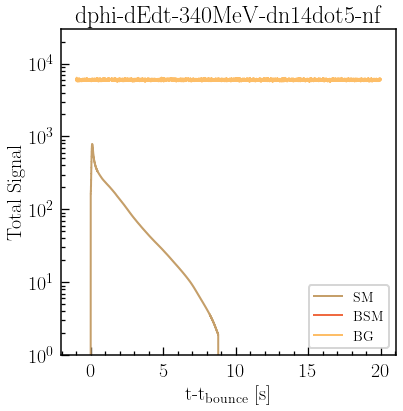

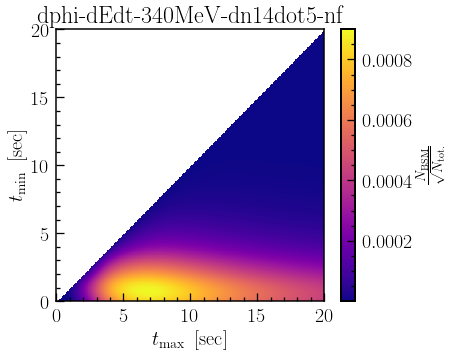

(0.0008994154366348539, 0.7000000000000001, 6.800000000000001)
./data/dphi-dEdt-200MeV-dn13dot5-nf.csv
./data/dphi-dEdt-200MeV-dn13dot5-nf_div6.csv
dphi-dEdt-200MeV-dn13dot5-nf
./data/dphi-dEdt-200MeV-dn13dot5-nf_params.txt
40263.27945331943
198081.11721088225


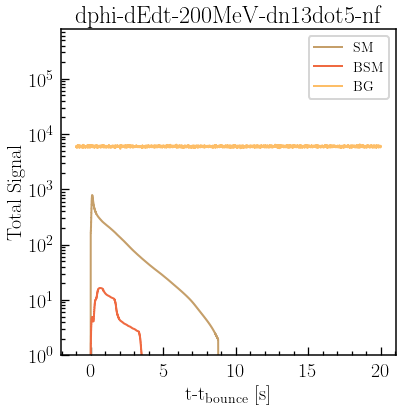

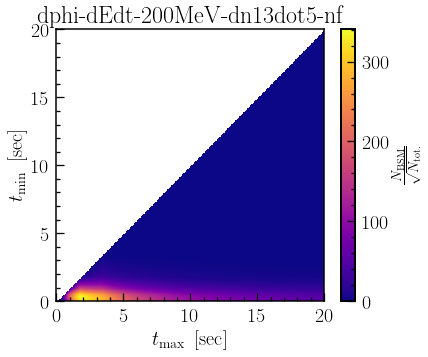

(340.2817704486006, 0.2, 1.8)
./data/dphi-dEdt-10MeV-nf.csv
./data/dphi-dEdt-10MeV-nf_div6.csv
dphi-dEdt-10MeV-nf
./data/dphi-dEdt-10MeV-nf_params.txt
124474.44167082141
198081.11721088225


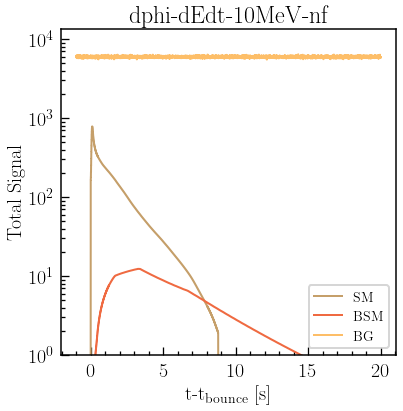

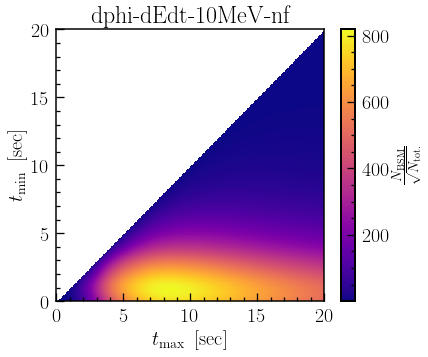

(818.6853462823201, 0.8, 8.4)
./data/dphi-dEdt-200MeV-dn14dot1-nf.csv
./data/dphi-dEdt-200MeV-dn14dot1-nf_div6.csv
dphi-dEdt-200MeV-dn14dot1-nf
./data/dphi-dEdt-200MeV-dn14dot1-nf_params.txt
3698.100632982258
198081.11721088225


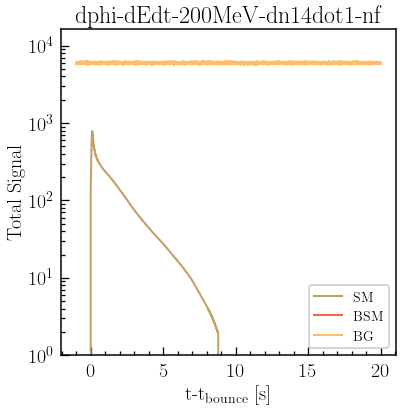

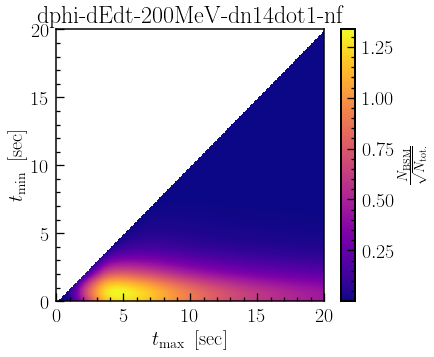

(1.3359262079848122, 0.5, 4.7)
./data/dphi-dEdt-380MeV-dn14-nf.csv
./data/dphi-dEdt-380MeV-dn14-nf_div6.csv
dphi-dEdt-380MeV-dn14-nf
./data/dphi-dEdt-380MeV-dn14-nf_params.txt
122.3063375321149
198081.11721088225


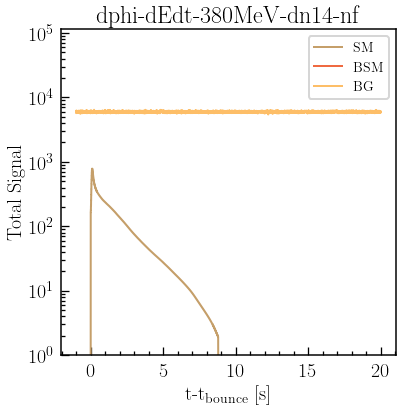

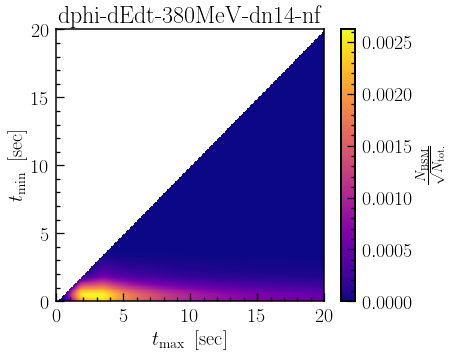

(0.0026219589194056425, 0.4, 3.3000000000000003)
./data/dphi-dEdt-360MeV-dn13dot5-nf.csv
./data/dphi-dEdt-360MeV-dn13dot5-nf_div6.csv
dphi-dEdt-360MeV-dn13dot5-nf
./data/dphi-dEdt-360MeV-dn13dot5-nf_params.txt
1553.1197765583854
198081.11721088225


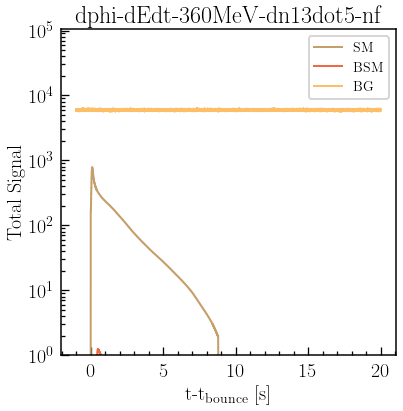

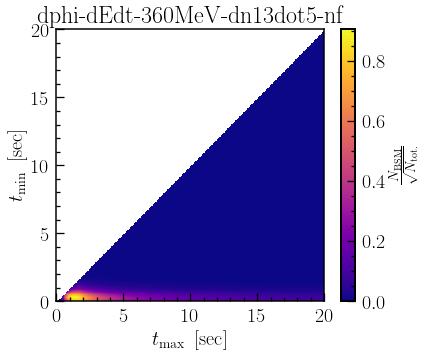

(0.9046473424327814, 0.2, 1.4000000000000001)
./data/dphi-dEdt-360MeV-dn13dot9-nf.csv
./data/dphi-dEdt-360MeV-dn13dot9-nf_div6.csv
dphi-dEdt-360MeV-dn13dot9-nf
./data/dphi-dEdt-360MeV-dn13dot9-nf_params.txt
682.8122894211683
198081.11721088225


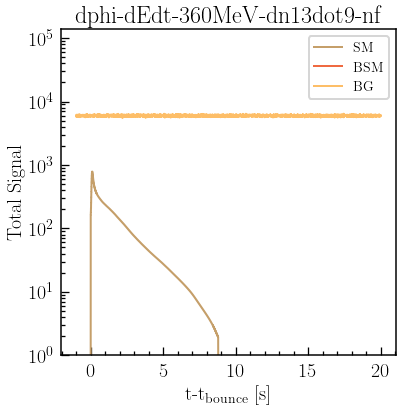

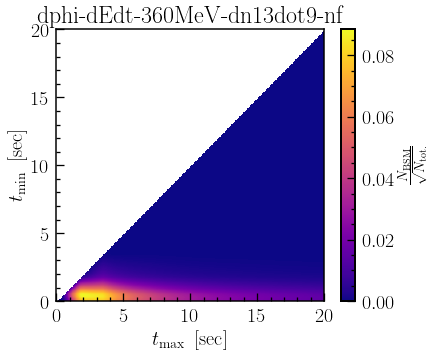

(0.08840729343626208, 0.4, 2.0)
./data/dphi-dEdt-100MeV-dn13-nf.csv
./data/dphi-dEdt-100MeV-dn13-nf_div6.csv
dphi-dEdt-100MeV-dn13-nf
./data/dphi-dEdt-100MeV-dn13-nf_params.txt
137265.82759751508
198081.11721088225


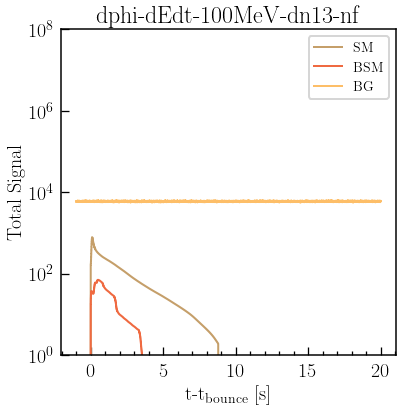

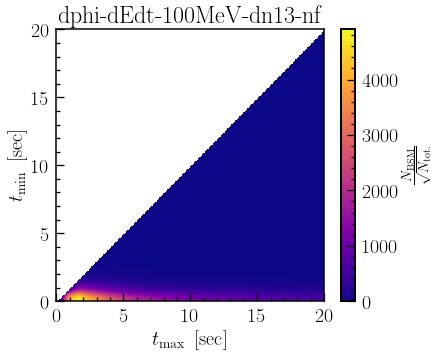

(4905.702006365027, 0.0, 1.7000000000000002)
./data/dphi-dEdt-100MeV-dn13dot8-nf.csv
./data/dphi-dEdt-100MeV-dn13dot8-nf_div6.csv
dphi-dEdt-100MeV-dn13dot8-nf
./data/dphi-dEdt-100MeV-dn13dot8-nf_params.txt
7292.366468882593
198081.11721088225


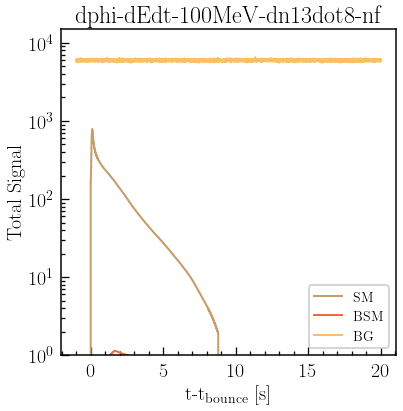

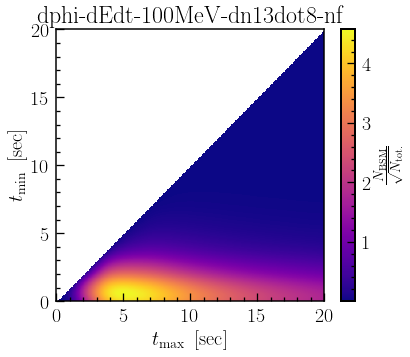

(4.5731120454620395, 0.5, 5.1000000000000005)
./data/dphi-dEdt-340MeV-dn13-nf.csv
./data/dphi-dEdt-340MeV-dn13-nf_div6.csv
dphi-dEdt-340MeV-dn13-nf
./data/dphi-dEdt-340MeV-dn13-nf_params.txt
1926.0393152188904
198081.11721088225


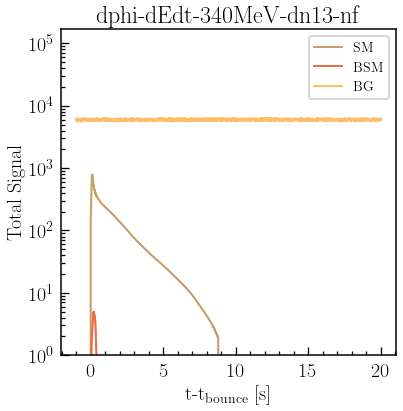

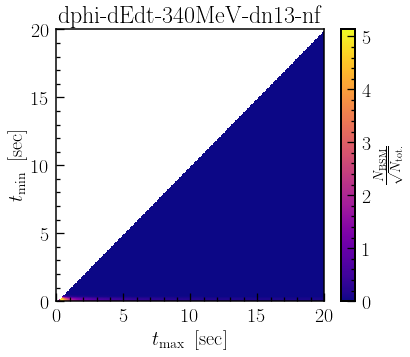

(5.130602589593764, 0.1, 0.4)
./data/dphi-dEdt-200MeV-dn14dot5-nf.csv
./data/dphi-dEdt-200MeV-dn14dot5-nf_div6.csv
dphi-dEdt-200MeV-dn14dot5-nf
./data/dphi-dEdt-200MeV-dn14dot5-nf_params.txt
505.4330183030344
198081.11721088225


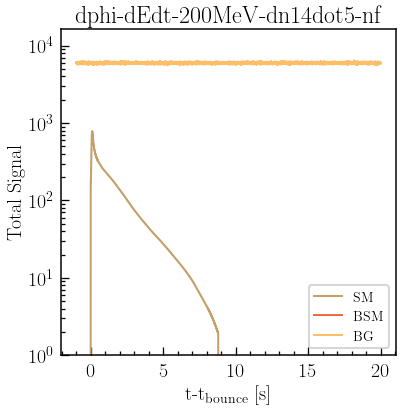

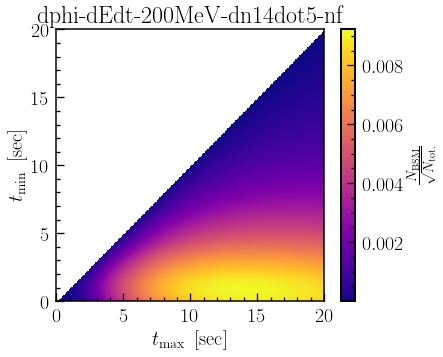

(0.009216196195097837, 0.7000000000000001, 14.200000000000001)
./data/dphi-dEdt-200MeV-dn14-nf.csv
./data/dphi-dEdt-200MeV-dn14-nf_div6.csv
dphi-dEdt-200MeV-dn14-nf
./data/dphi-dEdt-200MeV-dn14-nf_params.txt
5766.4310480596705
198081.11721088225


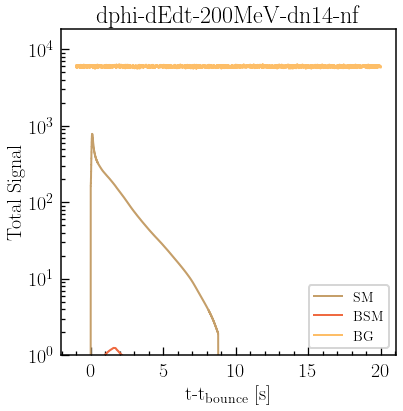

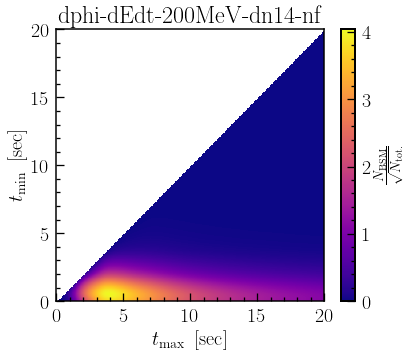

(4.037504496651309, 0.5, 3.9000000000000004)
./data/dphi-dEdt-340MeV-dn13dot5-nf.csv
./data/dphi-dEdt-340MeV-dn13dot5-nf_div6.csv
dphi-dEdt-340MeV-dn13dot5-nf
./data/dphi-dEdt-340MeV-dn13dot5-nf_params.txt
3635.9848391078576
198081.11721088225


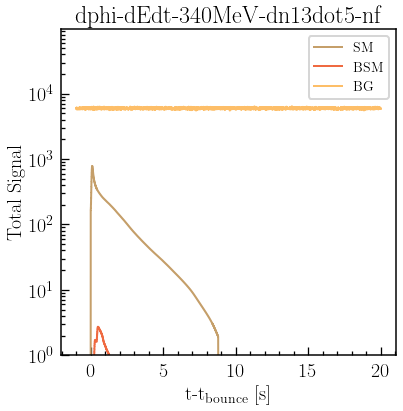

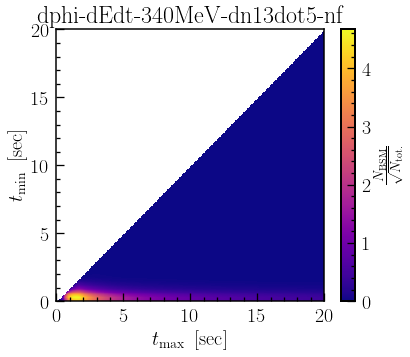

(4.668838543932907, 0.2, 1.5)
./data/dphi-dEdt-300MeV-dn14dot3-nf.csv
./data/dphi-dEdt-300MeV-dn14dot3-nf_div6.csv
dphi-dEdt-300MeV-dn14dot3-nf
./data/dphi-dEdt-300MeV-dn14dot3-nf_params.txt
657.1754440395538
198081.11721088225


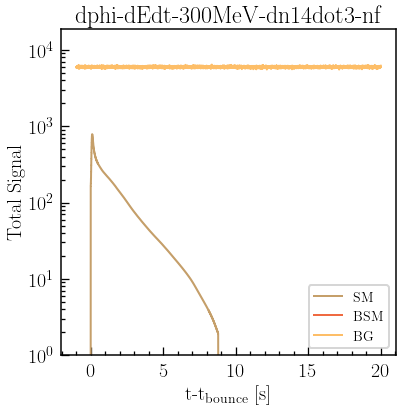

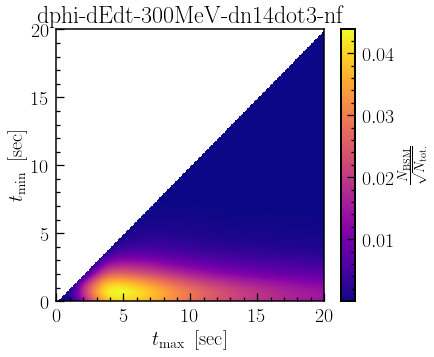

(0.04385451905454829, 0.6000000000000001, 4.6000000000000005)
./data/dphi-dEdt-340MeV-dn14dot3-nf.csv
./data/dphi-dEdt-340MeV-dn14dot3-nf_div6.csv
dphi-dEdt-340MeV-dn14dot3-nf
./data/dphi-dEdt-340MeV-dn14dot3-nf_params.txt
281.8844478350149
198081.11721088225


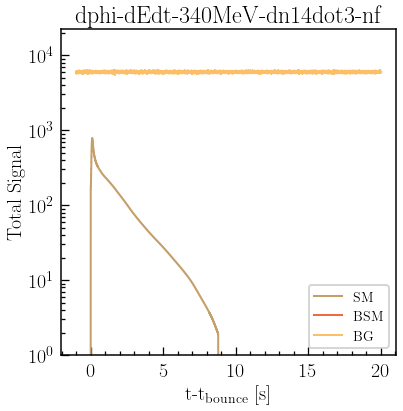

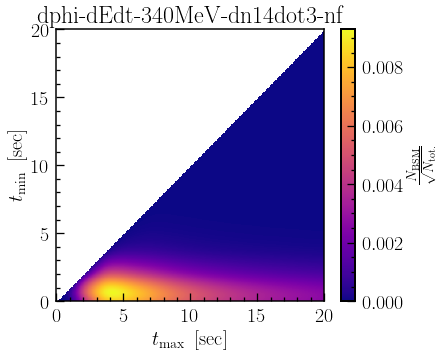

(0.009290664239642865, 0.6000000000000001, 4.2)
./data/dphi-dEdt-150MeV-dn14-nf.csv
./data/dphi-dEdt-150MeV-dn14-nf_div6.csv
dphi-dEdt-150MeV-dn14-nf
./data/dphi-dEdt-150MeV-dn14-nf_params.txt
5131.266121004467
198081.11721088225


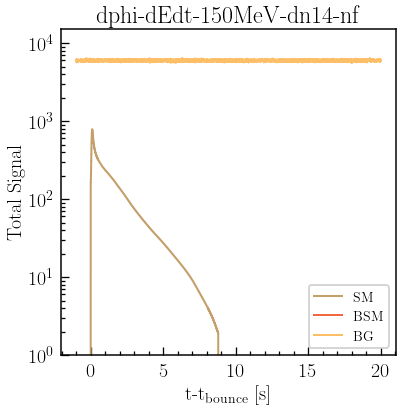

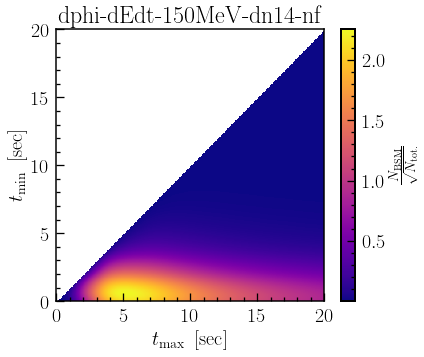

(2.2532756734726718, 0.5, 5.1000000000000005)
./data/dphi-dEdt-360MeV-dn12dot8-nf.csv
./data/dphi-dEdt-360MeV-dn12dot8-nf_div6.csv
dphi-dEdt-360MeV-dn12dot8-nf
./data/dphi-dEdt-360MeV-dn12dot8-nf_params.txt
875.8944360606029
198081.11721088225


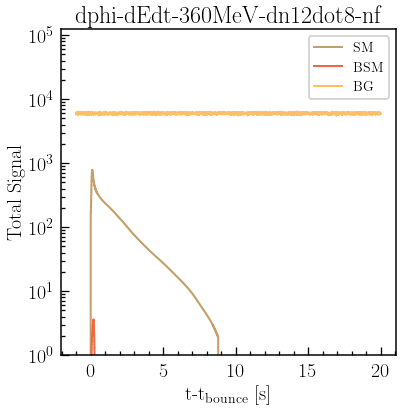

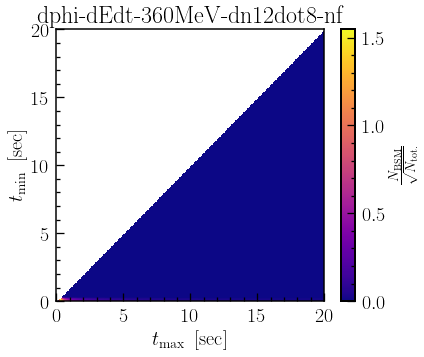

(1.546872153739514, 0.0, 0.30000000000000004)
./data/dphi-dEdt-1MeV-dn12dot3-nf.csv
./data/dphi-dEdt-1MeV-dn12dot3-nf_div6.csv
dphi-dEdt-1MeV-dn12dot3-nf
./data/dphi-dEdt-1MeV-dn12dot3-nf_params.txt
2153531.020939762
198081.11721088225


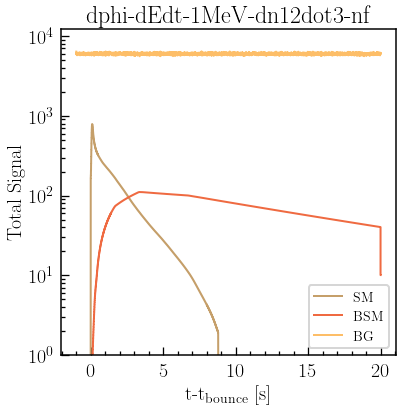

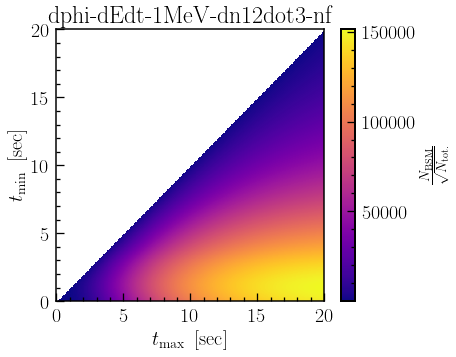

(151284.14728139108, 0.9, 20.0)
./data/dphi-dEdt-300MeV-dn13dot9-nf.csv
./data/dphi-dEdt-300MeV-dn13dot9-nf_div6.csv
dphi-dEdt-300MeV-dn13dot9-nf
./data/dphi-dEdt-300MeV-dn13dot9-nf_params.txt
3592.740985516665
198081.11721088225


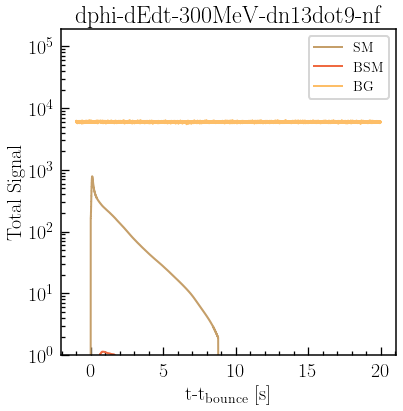

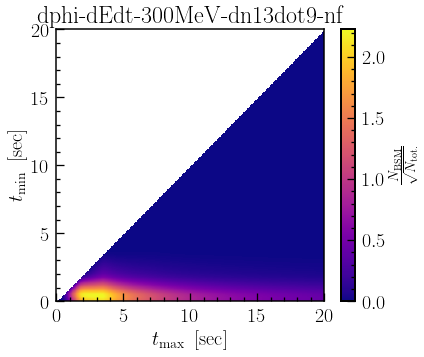

(2.2263848376278474, 0.30000000000000004, 3.4000000000000004)
./data/dphi-dEdt-360MeV-dn13-nf.csv
./data/dphi-dEdt-360MeV-dn13-nf_div6.csv
dphi-dEdt-360MeV-dn13-nf
./data/dphi-dEdt-360MeV-dn13-nf_params.txt
743.5782481312353
198081.11721088225


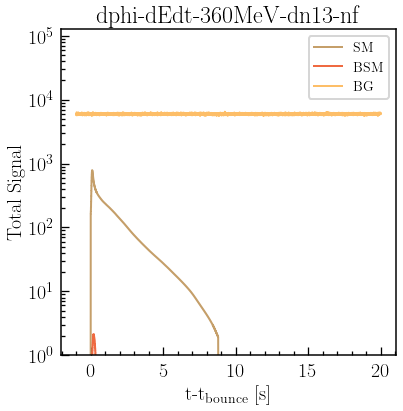

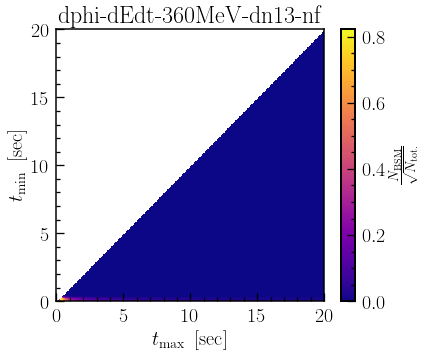

(0.8217484187314312, 0.1, 0.30000000000000004)
./data/dphi-dEdt-1MeV-dn13-nf.csv
./data/dphi-dEdt-1MeV-dn13-nf_div6.csv
dphi-dEdt-1MeV-dn13-nf
./data/dphi-dEdt-1MeV-dn13-nf_params.txt
5929.415842019565
198081.11721088225


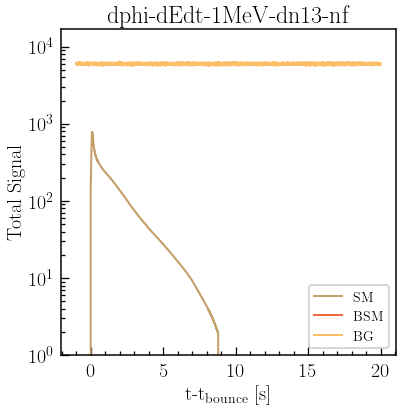

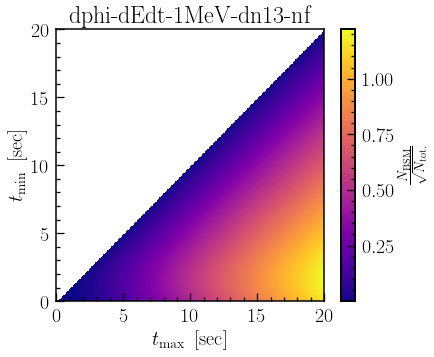

(1.2215218791170628, 1.5, 20.0)
./data/dphi-dEdt-100MeV-dn14-nf.csv
./data/dphi-dEdt-100MeV-dn14-nf_div6.csv
dphi-dEdt-100MeV-dn14-nf
./data/dphi-dEdt-100MeV-dn14-nf_params.txt
2856.0603437681298
198081.11721088225


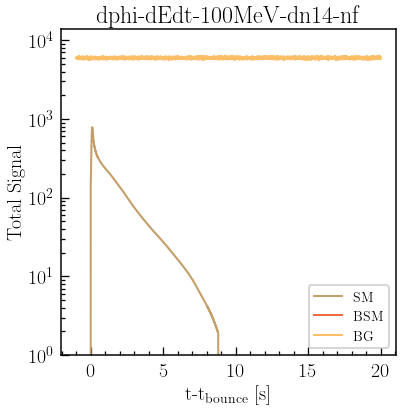

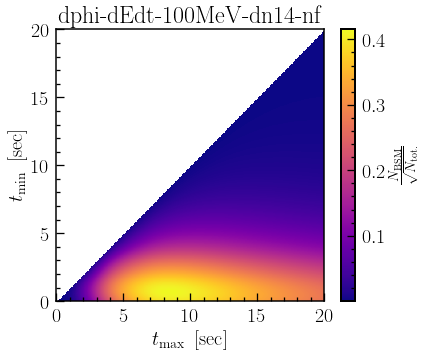

(0.41516204979325266, 0.6000000000000001, 8.4)
./data/dphi-dEdt-340MeV-dn14-nf.csv
./data/dphi-dEdt-340MeV-dn14-nf_div6.csv
dphi-dEdt-340MeV-dn14-nf
./data/dphi-dEdt-340MeV-dn14-nf_params.txt
1010.0662633374318
198081.11721088225


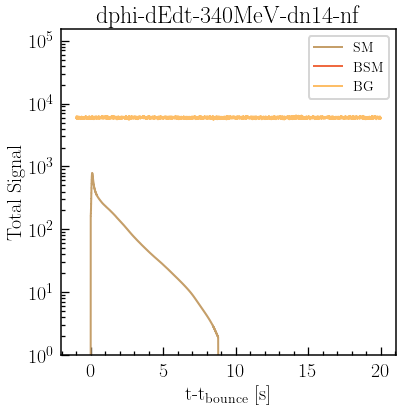

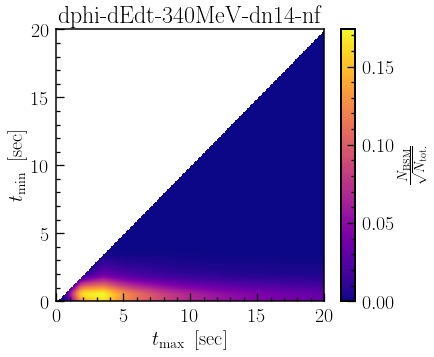

(0.17374295934178008, 0.4, 3.4000000000000004)
./data/dphi-dEdt-100MeV-dn13dot3-nf.csv
./data/dphi-dEdt-100MeV-dn13dot3-nf_div6.csv
dphi-dEdt-100MeV-dn13dot3-nf
./data/dphi-dEdt-100MeV-dn13dot3-nf_params.txt
58668.44143379478
198081.11721088225


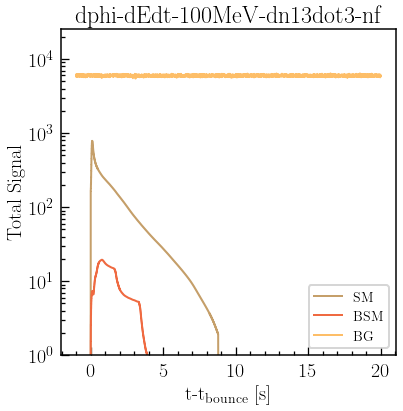

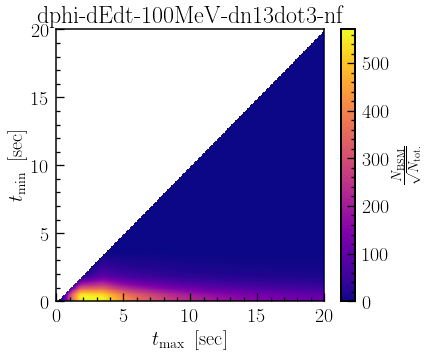

(570.8389110203134, 0.2, 2.2)
./data/dphi-dEdt-200MeV-dn14dot2-nf.csv
./data/dphi-dEdt-200MeV-dn14dot2-nf_div6.csv
dphi-dEdt-200MeV-dn14dot2-nf
./data/dphi-dEdt-200MeV-dn14dot2-nf_params.txt
2350.23718437554
198081.11721088225


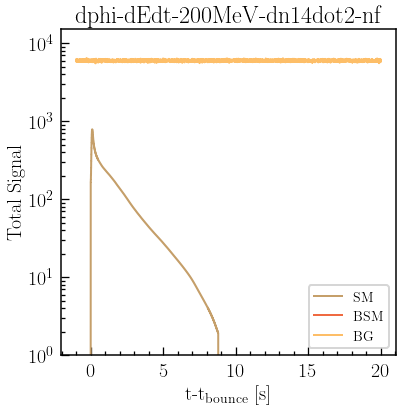

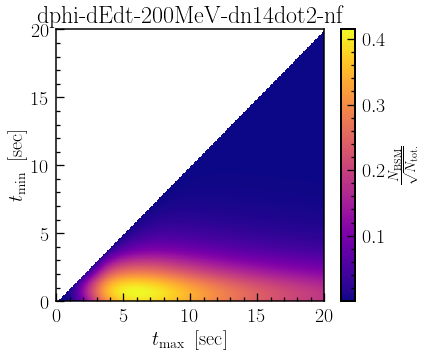

(0.41469433070778905, 0.6000000000000001, 6.0)
./data/dphi-dEdt-200MeV-dn13-nf.csv
./data/dphi-dEdt-200MeV-dn13-nf_div6.csv
dphi-dEdt-200MeV-dn13-nf
./data/dphi-dEdt-200MeV-dn13-nf_params.txt
69055.67071182712
198081.11721088225


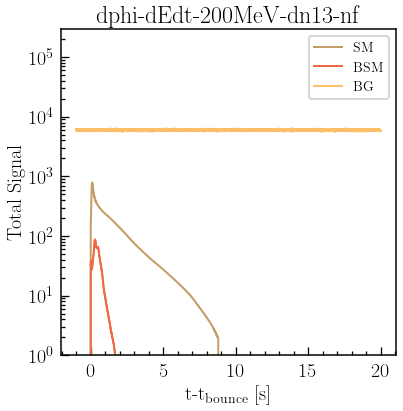

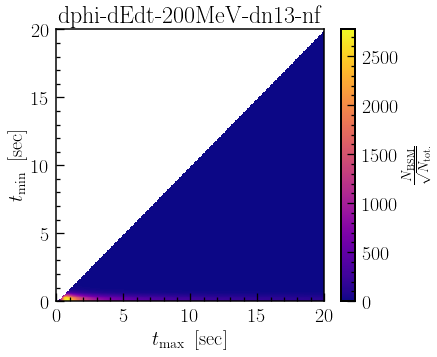

(2774.5519687565975, 0.0, 0.8)
./data/dphi-dEdt-340MeV-dn12dot3-nf.csv
./data/dphi-dEdt-340MeV-dn12dot3-nf_div6.csv
dphi-dEdt-340MeV-dn12dot3-nf
./data/dphi-dEdt-340MeV-dn12dot3-nf_params.txt
1994.6479342697012
198081.11721088225


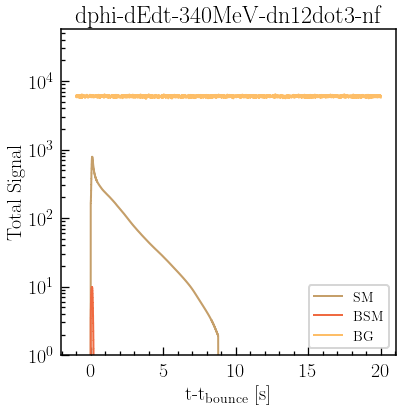

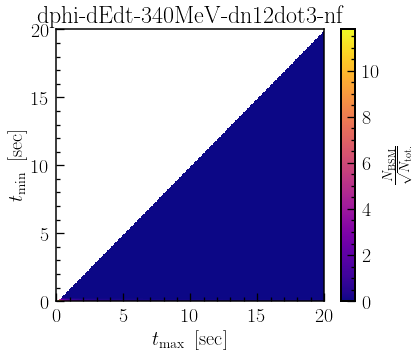

(11.788455662283923, 0.0, 0.2)
./data/dphi-dEdt-10MeV-dn13dot3-nf.csv
./data/dphi-dEdt-10MeV-dn13dot3-nf_div6.csv
dphi-dEdt-10MeV-dn13dot3-nf
./data/dphi-dEdt-10MeV-dn13dot3-nf_params.txt
21640.364827381876
198081.11721088225


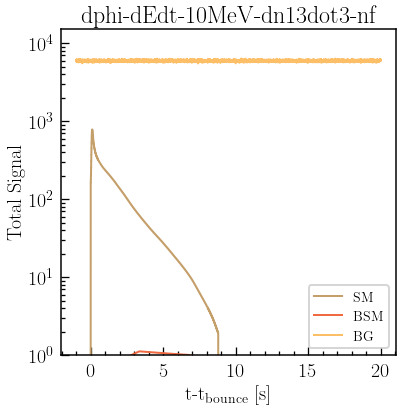

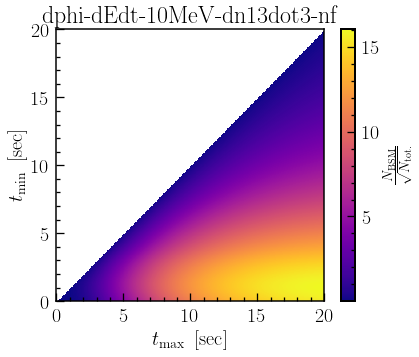

(16.036144770740066, 1.0, 20.0)
./data/dphi-dEdt-340MeV-dn13dot8-nf.csv
./data/dphi-dEdt-340MeV-dn13dot8-nf_div6.csv
dphi-dEdt-340MeV-dn13dot8-nf
./data/dphi-dEdt-340MeV-dn13dot8-nf_params.txt
2064.8376851396883
198081.11721088225


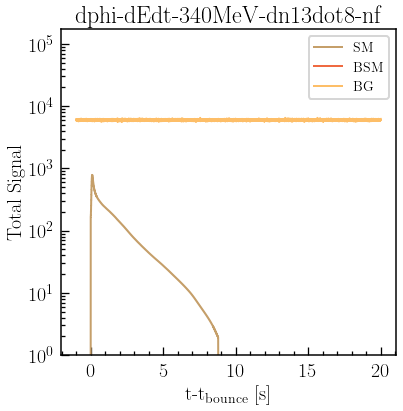

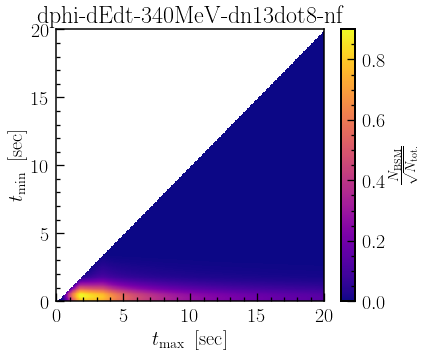

(0.8993857109189776, 0.30000000000000004, 1.9000000000000001)
./data/dphi-dEdt-200MeV-dn12dot3-nf.csv
./data/dphi-dEdt-200MeV-dn12dot3-nf_div6.csv
dphi-dEdt-200MeV-dn12dot3-nf
./data/dphi-dEdt-200MeV-dn12dot3-nf_params.txt
222572.44634802875
198081.11721088225


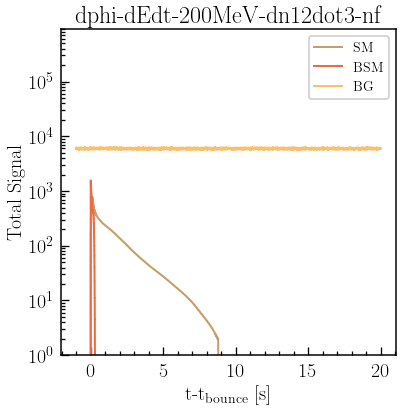

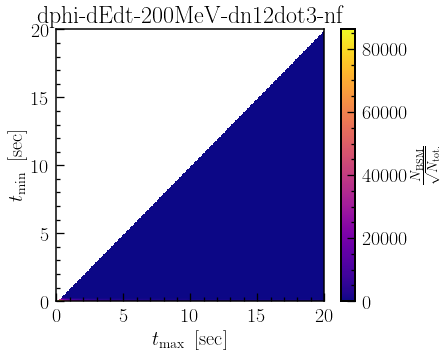

(86194.85623583931, 0.0, 0.2)
./data/dphi-dEdt-150MeV-dn14dot3-nf.csv
./data/dphi-dEdt-150MeV-dn14dot3-nf_div6.csv
dphi-dEdt-150MeV-dn14dot3-nf
./data/dphi-dEdt-150MeV-dn14dot3-nf_params.txt
1179.8092365143684
198081.11721088225


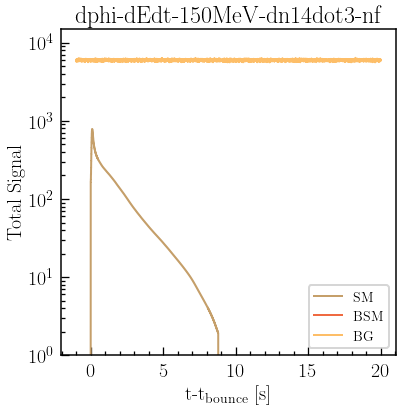

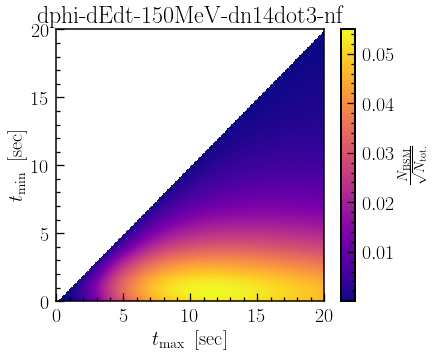

(0.0549259319916473, 0.7000000000000001, 11.700000000000001)
./data/dphi-dEdt-360MeV-dn13dot8-nf.csv
./data/dphi-dEdt-360MeV-dn13dot8-nf_div6.csv
dphi-dEdt-360MeV-dn13dot8-nf
./data/dphi-dEdt-360MeV-dn13dot8-nf_params.txt
943.3393777523022
198081.11721088225


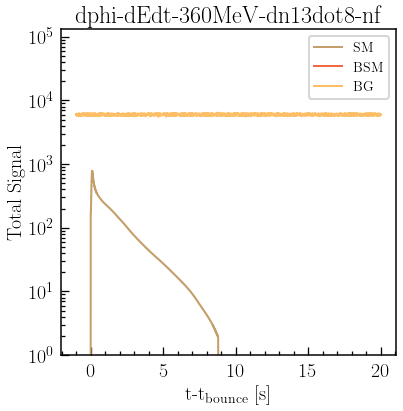

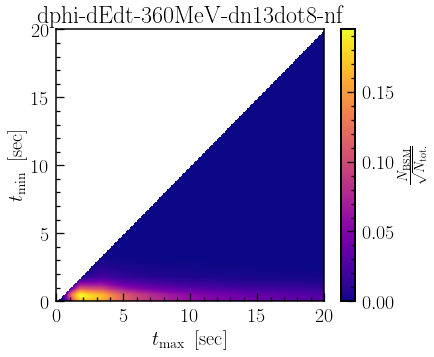

(0.19498336321862553, 0.30000000000000004, 1.8)
./data/dphi-dEdt-1MeV-dn13dot3-nf.csv
./data/dphi-dEdt-1MeV-dn13dot3-nf_div6.csv
dphi-dEdt-1MeV-dn13dot3-nf
./data/dphi-dEdt-1MeV-dn13dot3-nf_params.txt
381.5784080847219
198081.11721088225


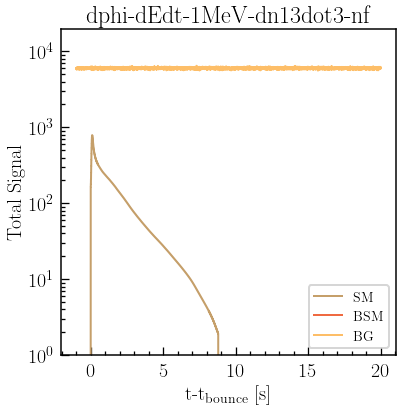

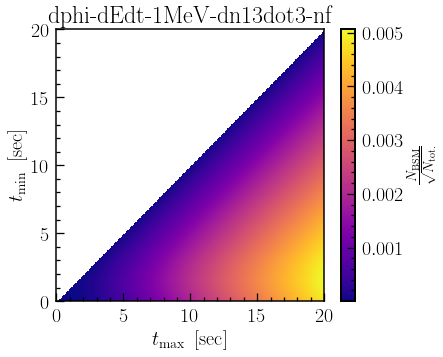

(0.005062315906798176, 1.5, 20.0)
./data/dphi-dEdt-380MeV-dn12dot3-nf.csv
./data/dphi-dEdt-380MeV-dn12dot3-nf_div6.csv
dphi-dEdt-380MeV-dn12dot3-nf
./data/dphi-dEdt-380MeV-dn12dot3-nf_params.txt
25.357781307129336
198081.11721088225


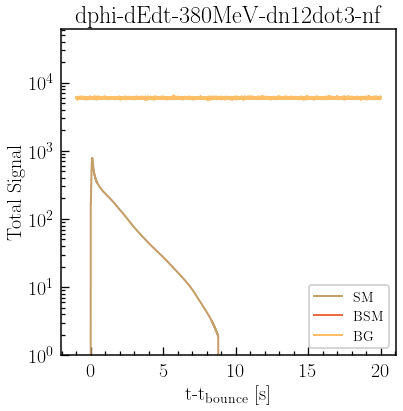

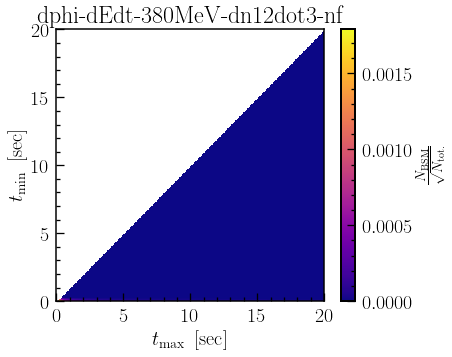

(0.0017896111699400308, 0.0, 0.2)
./data/dphi-dEdt-360MeV-dn12dot5-nf.csv
./data/dphi-dEdt-360MeV-dn12dot5-nf_div6.csv
dphi-dEdt-360MeV-dn12dot5-nf
./data/dphi-dEdt-360MeV-dn12dot5-nf_params.txt
900.1044544505723
198081.11721088225


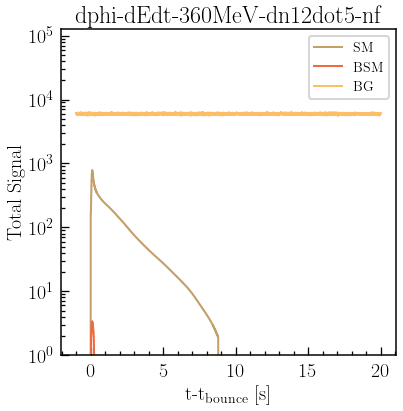

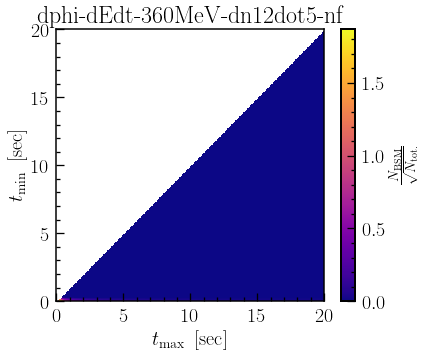

(1.8681799311120812, 0.0, 0.2)
./data/dphi-dEdt-300MeV-dn13dot8-nf.csv
./data/dphi-dEdt-300MeV-dn13dot8-nf_div6.csv
dphi-dEdt-300MeV-dn13dot8-nf
./data/dphi-dEdt-300MeV-dn13dot8-nf_params.txt
5166.411185165506
198081.11721088225


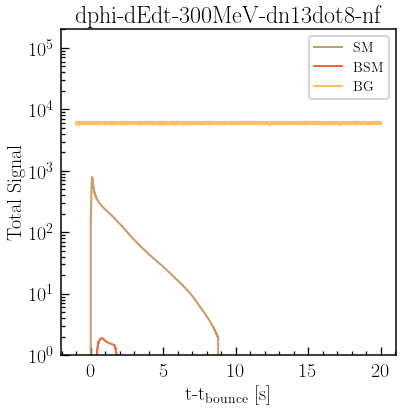

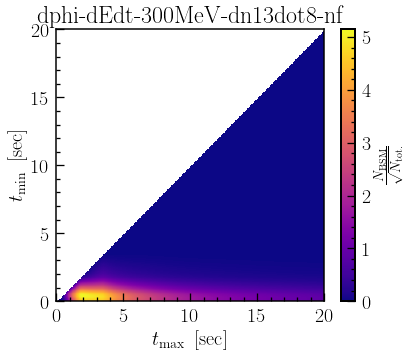

(5.143281164784639, 0.30000000000000004, 2.0)
./data/dphi-dEdt-10MeV-dn13dot5-nf.csv
./data/dphi-dEdt-10MeV-dn13dot5-nf_div6.csv
dphi-dEdt-10MeV-dn13dot5-nf
./data/dphi-dEdt-10MeV-dn13dot5-nf_params.txt
4748.048173881459
198081.11721088225


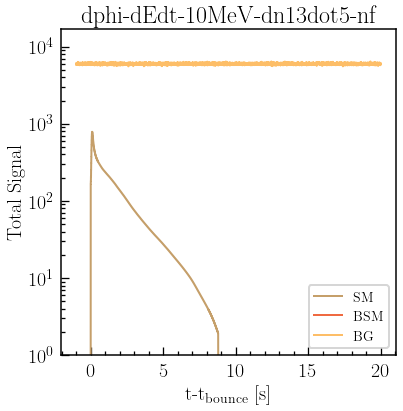

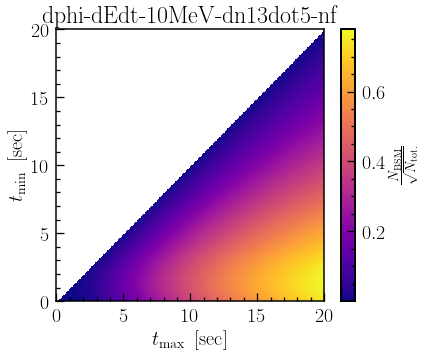

(0.777792509403298, 1.2000000000000002, 20.0)
./data/dphi-dEdt-150MeV-dn13dot9-nf.csv
./data/dphi-dEdt-150MeV-dn13dot9-nf_div6.csv
dphi-dEdt-150MeV-dn13dot9-nf
./data/dphi-dEdt-150MeV-dn13dot9-nf_params.txt
8023.927760436302
198081.11721088225


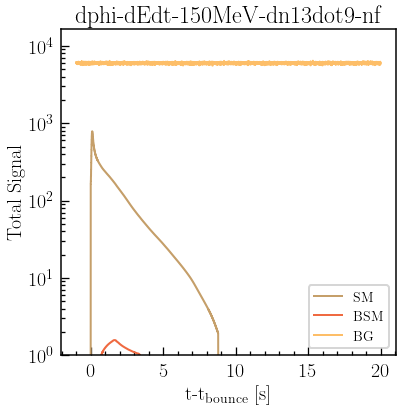

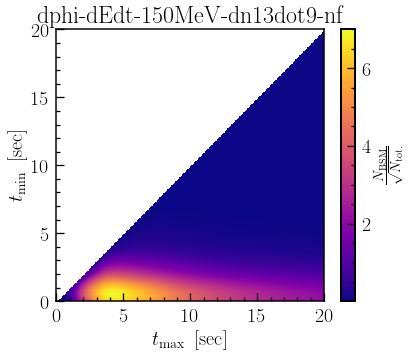

(7.000798599916379, 0.5, 4.2)
./data/dphi-dEdt-380MeV-dn13-nf.csv
./data/dphi-dEdt-380MeV-dn13-nf_div6.csv
dphi-dEdt-380MeV-dn13-nf
./data/dphi-dEdt-380MeV-dn13-nf_params.txt
158.66690814395258
198081.11721088225


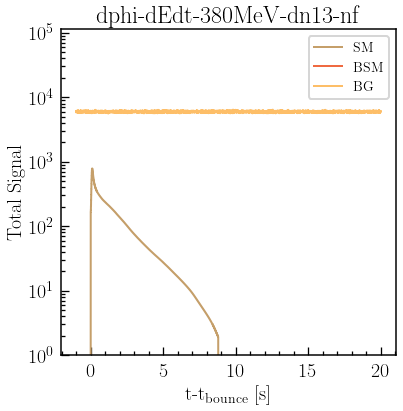

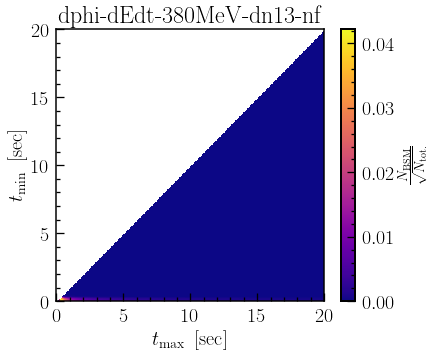

(0.04218675813882555, 0.1, 0.30000000000000004)


In [83]:
# bsm_fluxes = []
ahhhh = {}
for f, bsm_flux in zip(fs, bsm_fluxes):
    print(f)
    f_ = f.replace(".csv", "_div6.csv")
    print(f_)
    print(f.split("/")[-1].split(".")[0])
    title = f.split("/")[-1].split(".")[0]
    
    # bsm_flux = ParameterizedFlux(f_, f_, f_, 10*units["kpc"])
    
    params_f = f"{f.replace('.csv', '_params.txt')}"
    print(params_f)
    bsm_flux.write_params(params_f, scale=(units["m"] / (10 * units["kpc"]))**2)

    bsm_model = {
        'name': 'Analytic3Species',
        'param': {
            'filename': params_f
        }
    }

    sm_model = {
        'name': 'Analytic3Species',
        'param': {
            'filename': "data/sm_params.txt"
        }
    }

    bsm_sim = Simulation(
        # distance=1*u.kpc,
        distance=1.0 * u.m,
        model=bsm_model,
        **sim_kwargs
    )

    sm_sim = Simulation(
        model=sm_model,
        distance=1.0 * u.m,
        **sim_kwargs
    )

    dt = 0.004 * u.s

    bsm_sim.run()
    bsm_sim.rebin_result(dt)
    bsm_t, bsm_hits = bsm_sim.detector_signal(dt)
    print(bsm_hits.sum())

    sm_sim.run()
    sm_sim.rebin_result(dt)
    sm_t, sm_hits = sm_sim.detector_signal(dt)
    print(sm_hits.sum())

    sm_bg = sm_sim.detector.i3_bg(dt, size=sm_hits.size) + sm_sim.detector.dc_bg(dt, size=sm_hits.size)

    fig, ax = plt.subplots(1, figsize = (6,6))

    kwargs = {
        "step": "post",
        "edgecolor": "k",
        # "lw": "2"
    }
    ax.step(
        sm_t,
        sm_hits,
        label=r"SM",
        # **kwargs
    )
    ax.step(
        bsm_t,
        bsm_hits / 6,
        label=r"BSM",
        # **kwargs
    )
    ax.step(
        bsm_t,
        sm_bg,
        label=r"BG",
        # **kwargs
    )
    ax.legend(fontsize=14)
    ax.semilogy()
    # ax.set(xlim=(0.05, 0.65))
    ax.set_ylim(1.0, None)
    ax.set_xlabel(r't-t$_{\rm{bounce}}$ [s]', fontsize=20)
    ax.set_ylabel(fr'Total Signal', fontsize=20)
    ax.set_title(title)
    [x.set_linewidth(1.5) for x in ax.spines.values()]

    plt.show()

    tmins = np.linspace(0, 20, 201)
    tmaxs = np.linspace(0, 20, 201)

    significance = np.full(tmins.shape + tmaxs.shape, np.nan)

    for idx, tmin in enumerate(tmins):
        for jdx, tmax in enumerate(tmaxs):
            m = np.logical_and(tmin < bsm_t.value, bsm_t.value < tmax)
            n_bsm = (bsm_hits[m] + sm_hits[m] + sm_bg[m]).sum()
            n_sm = (sm_hits[m] + sm_bg[m]).sum()
            significance[idx, jdx] = 2 * (n_bsm - n_sm + n_sm * np.log(n_sm/n_bsm))
            # print()
            # break
        # break
            # print(2 * (n_bsm - n_sm + n_sm * np.log(n_sm/n_bsm)))


    fig, ax = plt.subplots(figsize=(6,5))
    [x.set_linewidth(1.5) for x in ax.spines.values()]

    im = ax.imshow(
        significance[::-1],
        extent=[0, 20, 0, 20],
        aspect="auto"
    )
    ax.set_title(title)
    ax.set(
        xlim=(0, 20),
        ylim=(0, 20),
        xlabel=r"$t_{\rm{max}}~\left[{\rm{sec}}\right]$",
        ylabel=r"$t_{\rm{min}}~\left[{\rm{sec}}\right]$",
    )

    cbar = plt.colorbar(im, label=r"$\frac{N_{\rm{BSM}}}{\sqrt{N_{\rm{tot.}}}}$")

    plt.show()
    
    fsplit = f.split("-")
    a = fsplit[2].replace("MeV", "")
    b = fsplit[3].replace("dn", "").replace("dot", ".")
    mass = float(a)
    try:
        coupling = -float(b)
    except ValueError:
        coupling = -13.0
    smax = 0
    for idx in range(significance.shape[0]):
        for jdx in range(significance.shape[1]):
            if np.isnan(significance[idx, jdx]):
                continue
            smax = max(smax, significance[idx, jdx])
            if smax != significance[idx, jdx]:
                continue
            tmin0 = tmins[idx]
            tmax0 = tmaxs[jdx]
    print((smax, tmin0, tmax0))
    ahhhh[(mass, coupling)] = (smax, tmin0, tmax0)

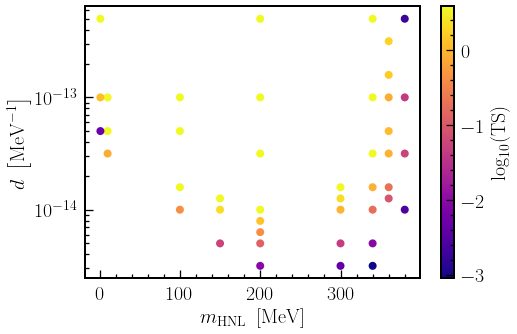

In [84]:
fig, ax = plt.subplots()

sct = ax.scatter(
    [k[0] for k in ahhhh.keys()],
    [10**k[1] for k in ahhhh.keys()],
    c = np.log10([v[0] for v in ahhhh.values()]),
    vmax=np.log10(3.841),
    # vmin=-1,
    # cmap="Greys",
    # edgecolor="k",
    # linewidth=0.5
)
ax.set(
    yscale="log",
    # xscale="log"
)
ax.set_xlabel(r"$m_{\rm{HNL}}~\left[{\rm{MeV}}\right]$", fontsize=20)
ax.set_ylabel(r"$d~\left[{\rm{MeV}}^{-1}\right]$", fontsize=20)
cbar = plt.colorbar(sct)
cbar.set_label(label=r"$\log_{10}({\rm{TS}})$", fontsize=20)
plt.show()

In [85]:
masses = sorted(list(set([k[0] for k in ahhhh.keys()])))

In [86]:
from scipy.interpolate import interp1d
from scipy.optimize import ridder

In [ ]:
np.log10

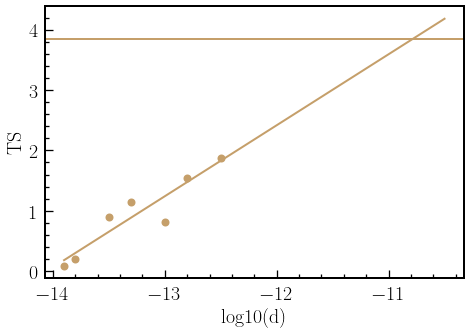

In [100]:
x = [-13.9, -13.8, -13.5, -13.3, -13.,  -12.8, -12.5]
y = [0.08840729, 0.19498336, 0.90464734, 1.14443265, 0.82174842, 1.54687215, 1.86817993]
fit = np.poly1d(np.polyfit(x, y, 1))

fig, ax = plt.subplots()

logds = np.linspace(-13.9, -10.5)

ax.plot(logds, fit(logds))
ax.scatter(x, y)
ax.set(
    xlabel="log10(d)",
    ylabel="TS",
    
)
ax.axhline(3.841)
plt.show()

In [91]:
s = []
for mass in masses:
    print(mass)
    
    
    logds = np.array([k[1] for k in ahhhh.keys() if k[0]==mass])
    sigs = np.array([v[0] for k, v in ahhhh.items() if k[0]==mass])
    
    
    sorter = np.argsort(logds)
    logds = logds[sorter]
    sigs = sigs[sorter]
    
    if mass > 340:
        print(logds)
        print(sigs)
        continue
    
    interper = interp1d(logds, np.log(sigs))
    f = lambda logd: np.exp(interper(logd)) - 3.841
    res = ridder(f, logds[0], logds[-1])
    s.append((mass, res, ))
    

1.0
10.0
100.0
150.0
200.0
300.0
340.0
360.0
[-13.9 -13.8 -13.5 -13.3 -13.  -12.8 -12.5]
[0.08840729 0.19498336 0.90464734 1.14443265 0.82174842 1.54687215
 1.86817993]
380.0
[-14.  -13.5 -13.  -12.3]
[0.00262196 0.05432211 0.04218676 0.00178961]


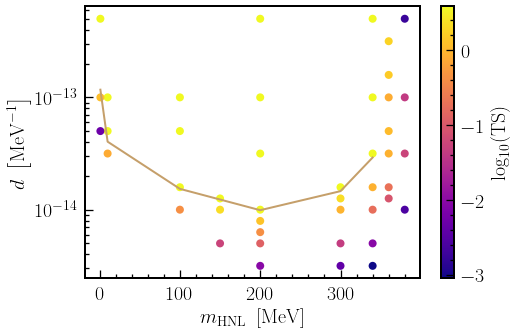

In [88]:
fig, ax = plt.subplots()

sct = ax.scatter(
    [k[0] for k in ahhhh.keys()],
    [10**k[1] for k in ahhhh.keys()],
    c = np.log10([v[0] for v in ahhhh.values()]),
    vmax=np.log10(3.841),
    # vmin=-1,
    # cmap="Greys",
    # edgecolor="k",
    # linewidth=0.5
)

ax.plot([x[0] for x in s], np.power(10, [x[1] for x in s]))

ax.set(
    yscale="log",
    # xscale="log"
)
ax.set_xlabel(r"$m_{\rm{HNL}}~\left[{\rm{MeV}}\right]$", fontsize=20)
ax.set_ylabel(r"$d~\left[{\rm{MeV}}^{-1}\right]$", fontsize=20)
cbar = plt.colorbar(sct)
cbar.set_label(label=r"$\log_{10}({\rm{TS}})$", fontsize=20)
plt.show()

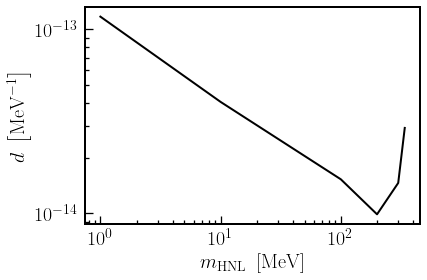

In [70]:
fig, ax = plt.subplots()

# sct = ax.scatter(
#     [k[0] for k in ahhhh.keys()],
#     [10**k[1] for k in ahhhh.keys()],
#     c = np.log10([v[0] for v in ahhhh.values()]),
#     vmax=np.log10(3.841),
#     # vmin=-1,
#     # cmap="Greys",
#     # edgecolor="k",
#     # linewidth=0.5
# )

ax.plot([x[0] for x in s], np.power(10, [x[1] for x in s]), c="k")

ax.set(
    yscale="log",
    xscale="log"
)
ax.set_xlabel(r"$m_{\rm{HNL}}~\left[{\rm{MeV}}\right]$", fontsize=20)
ax.set_ylabel(r"$d~\left[{\rm{MeV}}^{-1}\right]$", fontsize=20)
# cbar = plt.colorbar(sct)
# cbar.set_label(label=r"$\log_{10}({\rm{TS}})$", fontsize=20)
plt.show()